In [27]:
def adam_peer(x, y, w, b, alpha, momentw, momentb, sqw, sqb, beta1, beta2, epsilon, momentum_guidance_w, momentum_guidance_b, guidance_w, guidance_b, gradientw_max, gradientb_max):
    dl_dw = 0
    dl_db = 0
    N = len(x)
    
    mw, mb = momentw, momentb
    sw, sb = sqw, sqb
    
    for i in range(N):
        dl_dw += -2*x[i]*(y[i] - (w*x[i] +b))
        dl_db += -2*(y[i] - (w*x[i] + b))
    gradientw_current = (1/float(N))*dl_dw
    gradientb_current = (1/float(N))*dl_db
    
    #mw = (beta1*mw) - ((1 - beta1)*(gradientw_current))
    #mw = ((guidance_w-0.00000001)*mw) - ((1 - (guidance_w-0.00000001))*(gradientw_current))
    #mw = guidance_w*((beta1*mw) - ((1 - beta1)*(gradientw_current)))
    
    mw = (((1-guidance_w)*mw) - ((guidance_w)*(gradientw_current))) #XXXXXXXXXXXXXXXit works somewhat good
    #mb = (beta1*mb) - ((1 - beta1)*(gradientb_current))
    #mb = ((guidance_b-0.00000001)*mb) - ((1 - (guidance_b-0.00000001))*(gradientb_current))
    #mb = guidance_b*((beta1*mb) - ((1 - beta1)*(gradientb_current)))
    mb = (((1-guidance_b)*mb) - ((guidance_b)*(gradientb_current))) #XXXXXXXXXXXXXXXXXXXit works somewhat good
    
    sw= (beta2*sw) + ((1 - beta2)*(gradientw_current)**2)
    #sw = guidance_w*((beta2*sw) + ((1 - beta2)*(gradientw_current)**2))
    sb = (beta2*sb) + ((1 - beta2)*(gradientb_current)**2)
    #sb = guidance_b*((beta2*sb) + ((1 - beta2)*(gradientb_current)**2))
    
    mw_hat = mw / (1 - beta1)
    mb_hat = mb / (1 - beta1)
    
    sw_hat = sw / (1 - beta2)
    sb_hat = sb / (1 - beta2)
    
    #w = w + (alpha*((guidance_w*momentum_guidance_w) + mw_hat)) / np.sqrt(sw_hat + epsilon)
    w = w + (alpha*((guidance_w*(momentum_guidance_w / (1 - beta1))) + mw_hat)) / np.sqrt(sw_hat + epsilon)
    #the problem is in any of these guidance_w, momentum_guidance_w, mw_hat, sw_hat
    #b = b + (alpha*((guidance_b*momentum_guidance_b) + mb_hat)) / np.sqrt(sb_hat + epsilon)
    b = b + (alpha*((guidance_b*(momentum_guidance_b / (1 - beta1))) + mb_hat)) / np.sqrt(sb_hat + epsilon)
    
    for i in range(N):
        dl_dw += -2*x[i]*(y[i] - (w*x[i] +b))
        dl_db += -2*(y[i] - (w*x[i] + b))
    gradientw = (1/float(N))*dl_dw
    gradientb = (1/float(N))*dl_db
    
    if gradientw > gradientw_max:
        gradientw_max = gradientw
    if gradientb > gradientb_max:
        gradientb_max = gradientb
    
    return w, b, mw, mb, sw, sb, gradientw_max, gradientb_max, gradientw, gradientb

In [28]:
def momentum_peer(x, y, w, b, alpha, momentw, momentb, beta):
    dl_dw = 0
    dl_db = 0
    N = len(x)
    mw, mb = momentw, momentb
    for i in range(N):
        dl_dw += -2*x[i]*(y[i] - (w*x[i] +b))
        dl_db += -2*(y[i] - (w*x[i] + b))
        
    mw = beta*mw - alpha*(1/float(N))*dl_dw
    mb = beta*mb - alpha*(1/float(N))*dl_db
    
    w = w+mw
    b = b+mb
    
    return w, b, mw, mb

In [29]:
def guidance_decay(gradientw, gradientb, max_gradient_w, max_gradient_b):
    #guidance_w = 1 - (np.exp(-abs(gradientw)))
    guidance_w = 1 - (np.exp(-abs(((max_gradient_w - gradientw)  / max_gradient_w))*10))
    
    #guidance_w = 1 - (np.exp(-abs(abs(max_gradient_w) - abs(gradientw)) / abs(max_gradient_w)))
    #guidance_b = 1 - (np.exp(-abs(gradientb)))
    guidance_b = 1 - (np.exp(-abs(((max_gradient_b - gradientb) / max_gradient_b))*10))
    
    #guidance_b = 1 - (np.exp(-abs(abs(max_gradient_b) - abs(gradientb)) / abs(max_gradient_b)))
    return guidance_w, guidance_b

In [30]:
from matplotlib.pyplot import figure
import time
def train(x, y, w1, b1, w2, b2, alpha, epochs, beta1, beta2, epsilon):
    avg_loss_list = []
    w_list = []
    b_list = []
    img_list = []
    pred_val_at_diff_epoch = []
    mw1, mb1, mw2, mb2 = 0, 0, 0, 0
    sqw1, sqb1, sqw2, sqb2 = 0, 0, 0, 0
    guidance_w2, guidance_b2 = 1, 1
    gradientw_max, gradientb_max = 0.00000001, 0.00000001
    for num_of_epochs in range(epochs):
        xy = pd.concat([x, y], axis = 1)
        indexes = xy.index
        rand_indexes = np.random.choice(indexes, 15)
        xtrain = []
        ytrain = []
        for i in rand_indexes:
            xtrain.append(x[i])
            ytrain.append(y[i])
        w1, b1, mw1, mb1 = momentum_peer(x, y, w1, b1, alpha, mw1, mb1, 0.9)
        #gradientw1 = (671 - gradientw1) / 671 #not correct, 671 is cost not gradient replace with 1/N*dl_dw
        #gradientb1 = (671 - gradientb1) / 671 #not correct, above eq
        w2, b2, mw2, mb2, sw2, sb2, gradientw_max, gradientb_max, gradientw2, gradientb2 = adam_peer(xtrain, ytrain, w2, b2, alpha, mw2, mb2, sqw2, sqb2, beta1, beta2, epsilon, mw1, mb1, guidance_w2, guidance_b2, gradientw_max, gradientb_max)
        guidance_w2, guidance_b2 = guidance_decay(gradientw2, gradientb2, gradientw_max, gradientb_max)
        #guidance_w2, guidance_b2 = guidance_decay(gradientw2, gradientb2)
        #w2, b2, mw2, mb2, sw2, sb2, gradientw2, gradientb2 = adam_peer(xtrain, ytrain, w2, b2, alpha, mw2, mb2, sqw2, sqb2, beta1, beta2, epsilon, mw1, mb1, guidance_w1, guidance_b1)
        #guidance_w2, guidance_b2 = guidance_decay(gradientw2, gradientb2)
        
        if num_of_epochs%10 == 0:
            avg_loss_val1 = avg_loss(x, y, w1, b1)
            avg_loss_val2 = avg_loss(x, y, w2, b2)
            if avg_loss_val1 < avg_loss_val2:
                avg_loss_list.append(avg_loss_val1)
                w, b = w1, b1 
            elif avg_loss_val1 >= avg_loss_val2:
                avg_loss_list.append(avg_loss_val2)
                w, b = w2, b2
            w_list.append(w)
            b_list.append(b)
        if num_of_epochs%500 == 0:
            print("epoch: ", num_of_epochs,"average loss: ",avg_loss_val2)
            print(f"Momentum leader: gradient_w2 = {gradientw2}, gradient_b2 = {gradientb2}, MAX_w_gradient = {gradientw_max} and b = {gradientb_max}")
            print(f"Momentum leader: mw1 = {mw1}, mb1 = {mb1}")
            print(f"Momentum leader: guidance_w2 = {guidance_w2}, guidance_b2 = {guidance_b2}")
            #print(f"Adam follower: w2 = {w2}, b2 = {b2}")
            print(f"Adam follower: mw2 = {mw2}, mb2 = {mb2}, sw2 = {sw2}, sb2 = {sb2}")
            
            figure(figsize = (15, 10))
            plt.title(f"Epoch: {num_of_epochs}")
            plt.xlabel("X")
            plt.ylabel("y")
            plt.xlim(0, 9)
            plt.ylim(0, 50)
            
            plt.scatter(x, y)
            xt = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
            yt = []
            for i in range(10):
                yt.append(predict(xt[i], w2, b2))
                
            plt.plot(xt, yt, color = "red")
            
            plt.savefig(f"{num_of_epochs}.png")
            img_list.append(f"{num_of_epochs}.png")
            
            plt.show()
            
            if avg_loss(x, y, w2, b2) <= 38:
                return w_list, b_list, avg_loss_list, w, b, img_list, pred_val_at_diff_epoch
            print(avg_loss_val1, w1, b1)
            print(avg_loss_val2, w2, b2)
    return w_list, b_list, avg_loss_list, w, b, img_list, pred_val_at_diff_epoch

In [31]:
def avg_loss(x, y, w, b):
    N = len(x)
    total_error = 0
    for i in range(N):
        total_error += (y[i] - (w*x[i]+b))**2
    return total_error/float(N)

In [32]:
def predict(x, w, b):
    return w*x+b

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
dataset = load_boston()
df = pd.DataFrame(data = dataset.data, columns = dataset.feature_names)
df["Y"] = dataset.target
X = pd.concat((df["LSTAT"], df["RM"]), axis = 1)
y = pd.DataFrame(df["Y"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

epoch:  0 average loss:  667.8619017398267
Momentum leader: gradient_w2 = -787.1742141793846, gradient_b2 = -114.27495326091544, MAX_w_gradient = 1e-08 and b = 1e-08
Momentum leader: mw1 = 0.31688613697270474, mb1 = 0.04843027295285366
Momentum leader: guidance_w2 = 1.0, guidance_b2 = 1.0
Adam follower: mw2 = 394.09797333333336, mb2 = 57.21333333333333, sw2 = 1553.1321258544085, sb2 = 32.73365511111113


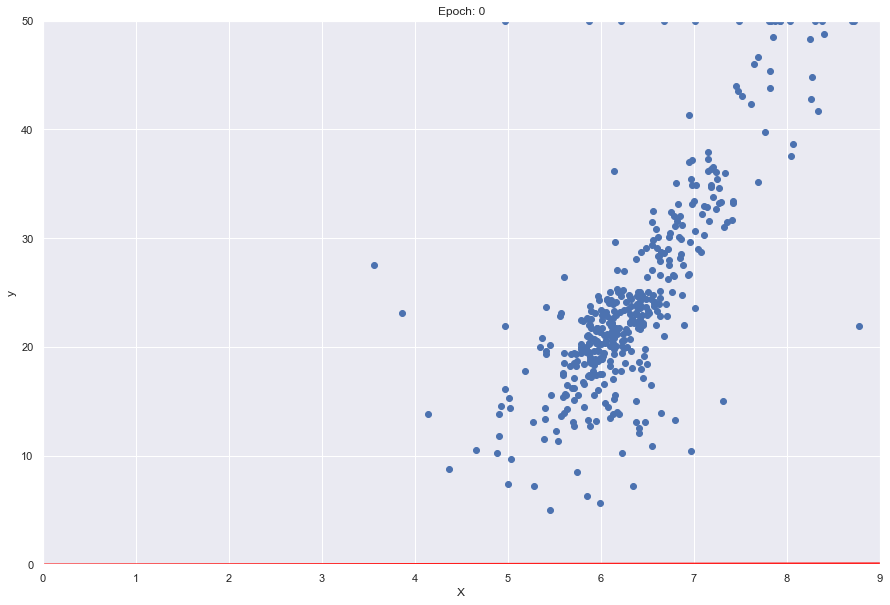

573.0312769351891 0.31688613697270474 0.04843027295285366
667.8619017398267 0.010008040795900714 0.010008464857622619
epoch:  500 average loss:  58.778973609501506
Momentum leader: gradient_w2 = 4.693105089358564, gradient_b2 = 2.1227272014204503, MAX_w_gradient = 97.53623360623833 and b = 16.25676332076239
Momentum leader: mw1 = 0.0012724411052219893, mb1 = -0.008166153587200839
Momentum leader: guidance_w2 = 0.9999265447883036, guidance_b2 = 0.9998324535273473
Adam follower: mw2 = -2.888360017302327, mb2 = -1.1473351094781674, sw2 = 0.07976935365546148, sb2 = 0.01291056130743171


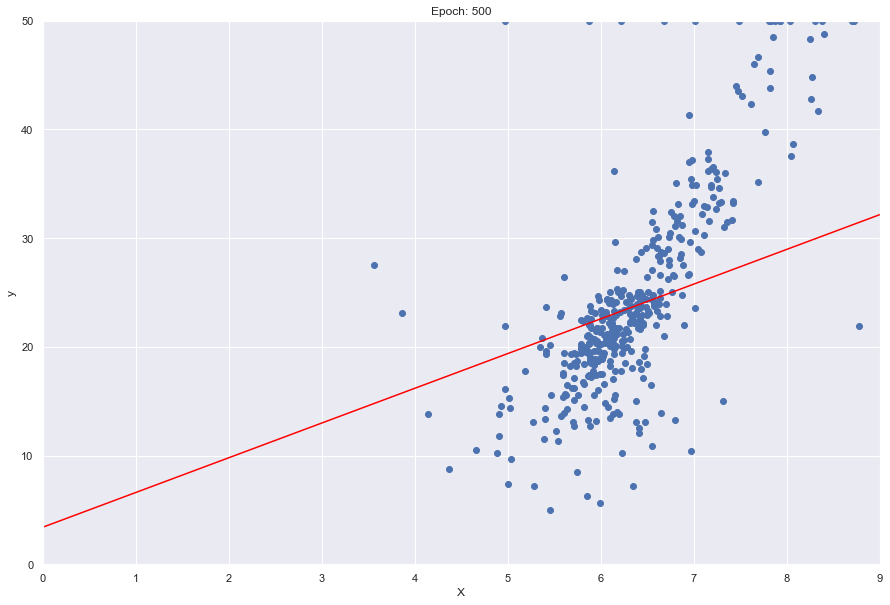

51.02845938424181 4.4686897495199105 -3.689214870927712
58.778973609501506 3.194497076867187 3.4163978847815955
epoch:  1000 average loss:  56.95385846017982
Momentum leader: gradient_w2 = -86.19455833784141, gradient_b2 = -10.486175646983776, MAX_w_gradient = 139.98378657527653 and b = 22.92924162937004
Momentum leader: mw1 = 0.0011191956086148529, mb1 = -0.007182668982979155
Momentum leader: guidance_w2 = 0.9999999038606624, guidance_b2 = 0.9999995312875
Adam follower: mw2 = 43.55919409177308, mb2 = 5.315342682131315, sw2 = 18.974173734802644, sb2 = 0.28253069424216043


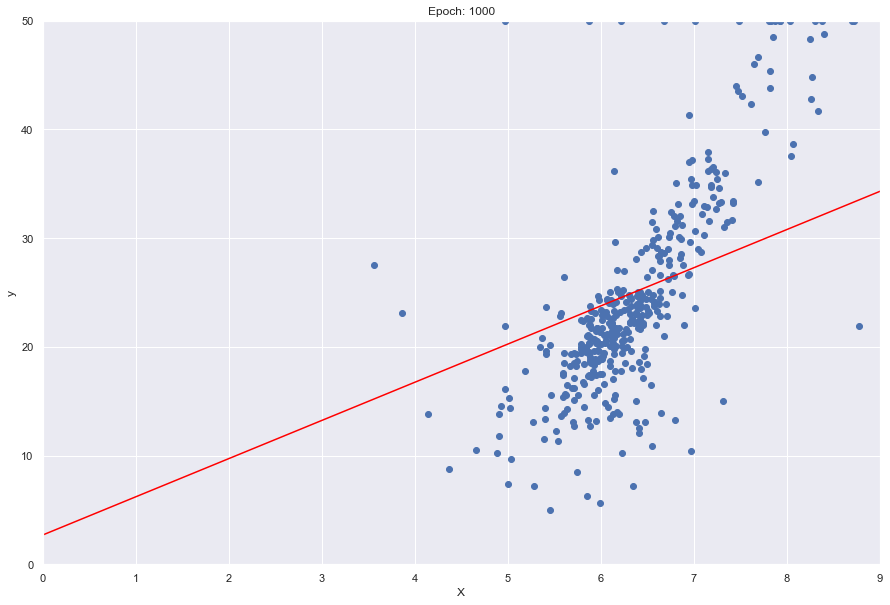

48.0243788980234 5.065703135431925 -7.5206715854229635
56.95385846017982 3.5112726310957894 2.7042802892978237
epoch:  1500 average loss:  60.558903542857216
Momentum leader: gradient_w2 = 6.641713178645702, gradient_b2 = 1.6449436019923651, MAX_w_gradient = 139.98378657527653 and b = 22.92924162937004
Momentum leader: mw1 = 0.000984406121869017, mb1 = -0.006317629611639393
Momentum leader: guidance_w2 = 0.9999270354585339, guidance_b2 = 0.9999069710742828
Adam follower: mw2 = -3.7886958386924063, mb2 = -0.8958712427403454, sw2 = 0.14354929893788715, sb2 = 0.008026343660933286


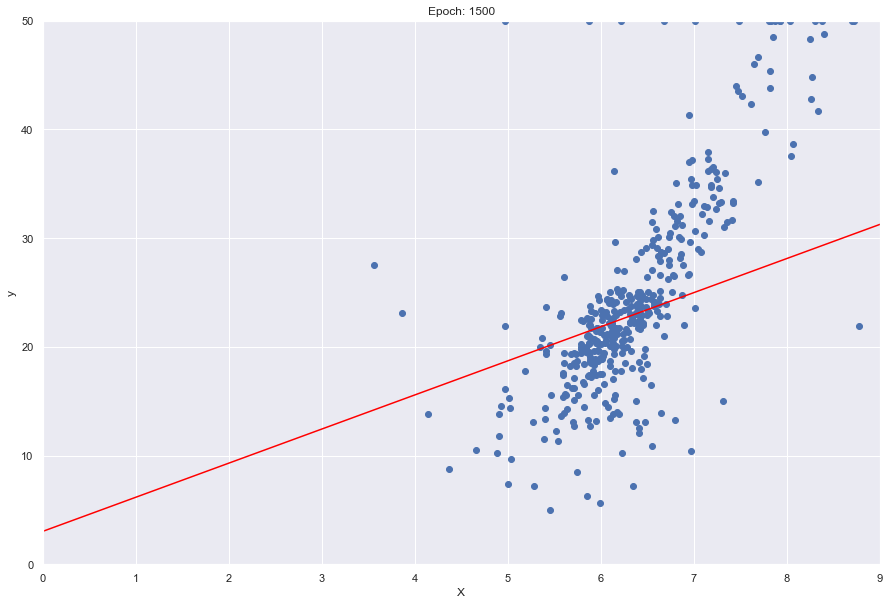

45.700314375897186 5.590815660366833 -10.890689673763678
60.558903542857216 3.1366758859854125 3.0359436113967324
epoch:  2000 average loss:  56.662423063878244
Momentum leader: gradient_w2 = 51.56290495929678, gradient_b2 = 8.482047683784415, MAX_w_gradient = 139.98378657527653 and b = 22.92924162937004
Momentum leader: mw1 = 0.0008658499062306263, mb1 = -0.005556770610541024
Momentum leader: guidance_w2 = 0.9981937615024837, guidance_b2 = 0.9981651135688764
Adam follower: mw2 = -26.223032188599603, mb2 = -4.315227838575794, sw2 = 6.876457323826835, sb2 = 0.18598674981696728


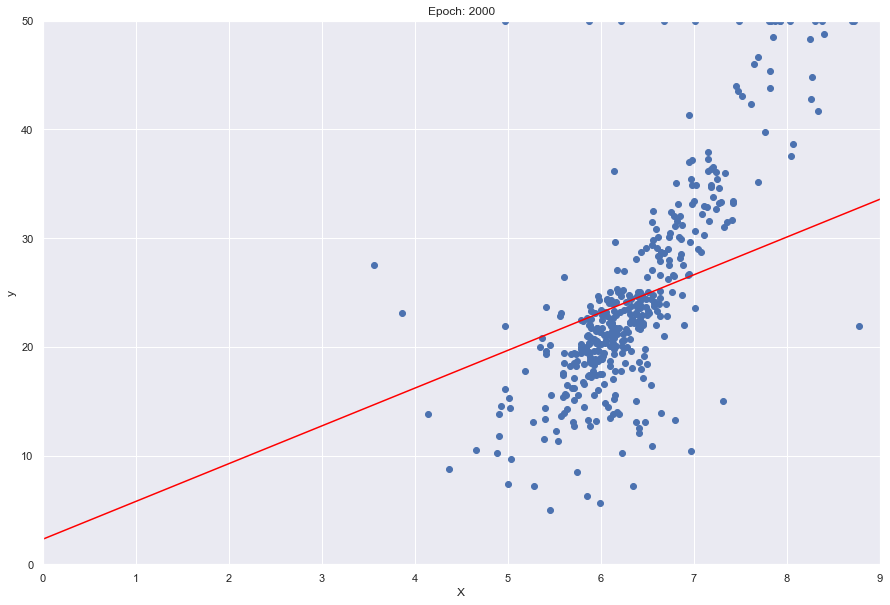

43.90233461876857 6.052686650779025 -13.854842152057481
56.662423063878244 3.4737810314293167 2.314097535857628
epoch:  2500 average loss:  55.55805359707558
Momentum leader: gradient_w2 = 71.2677962976508, gradient_b2 = 12.10173260400035, MAX_w_gradient = 139.98378657527653 and b = 22.92924162937004
Momentum leader: mw1 = 0.0007615719198252343, mb1 = -0.004887545094648239
Momentum leader: guidance_w2 = 0.9926190543743619, guidance_b2 = 0.991103879994372
Adam follower: mw2 = -36.10162844334861, mb2 = -6.124149751712391, sw2 = 13.033693882562856, sb2 = 0.37507535724820473


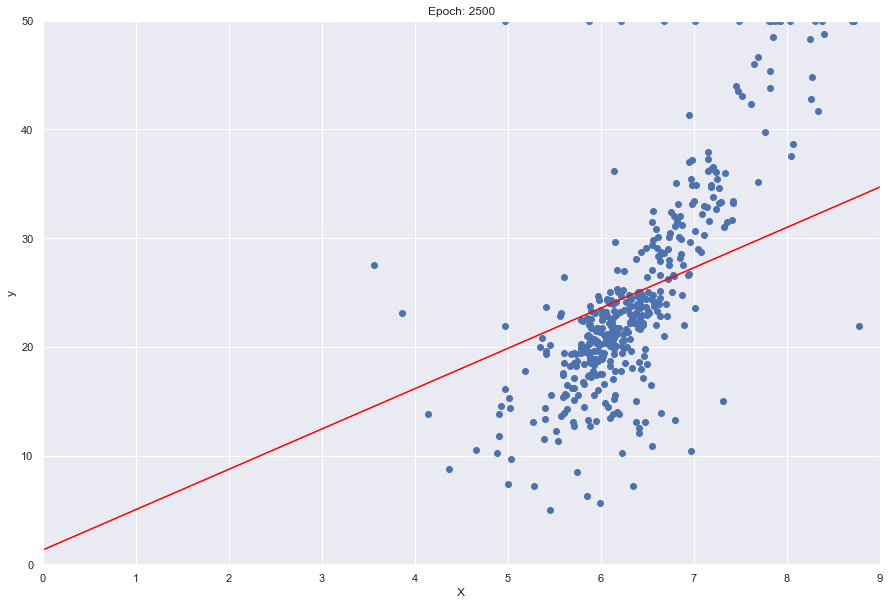

42.511352924298734 6.458932553618199 -16.46200914174607
55.55805359707558 3.7082318553851867 1.326623887872249
epoch:  3000 average loss:  54.87716437301577
Momentum leader: gradient_w2 = -3.8406564828113203, gradient_b2 = 0.08008298844594226, MAX_w_gradient = 139.98378657527653 and b = 22.92924162937004
Momentum leader: mw1 = 0.0006698525747856957, mb1 = -0.004298917253648162
Momentum leader: guidance_w2 = 0.9999654935529407, guidance_b2 = 0.9999529864105503
Adam follower: mw2 = 2.1816995980025435, mb2 = 0.001343461117564393, sw2 = 0.04759811610792364, sb2 = 1.8036068067633876e-08


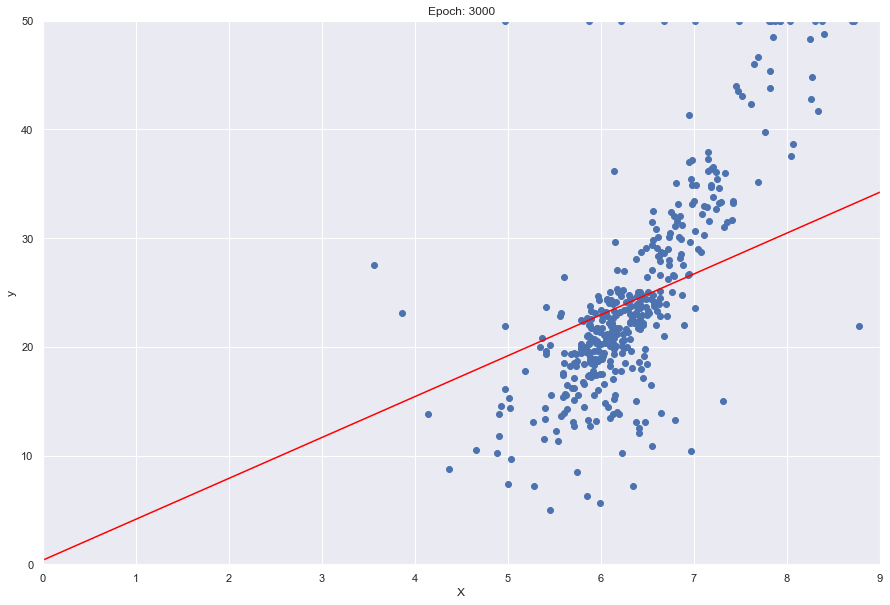

41.435239543890084 6.8162525347374485 -18.7551839233735
54.87716437301577 3.760069390943186 0.3860746417260838
epoch:  3500 average loss:  53.78600479234116
Momentum leader: gradient_w2 = 29.61940088976178, gradient_b2 = 6.192564903284536, MAX_w_gradient = 139.98378657527653 and b = 22.92924162937004
Momentum leader: mw1 = 0.0005891793805237666, mb1 = -0.003781180366795977
Momentum leader: guidance_w2 = 0.9996233082948202, guidance_b2 = 0.9993239691312946
Adam follower: mw2 = -15.25411489225752, mb2 = -3.167761701995394, sw2 = 2.327023121413326, sb2 = 0.10035874681445359


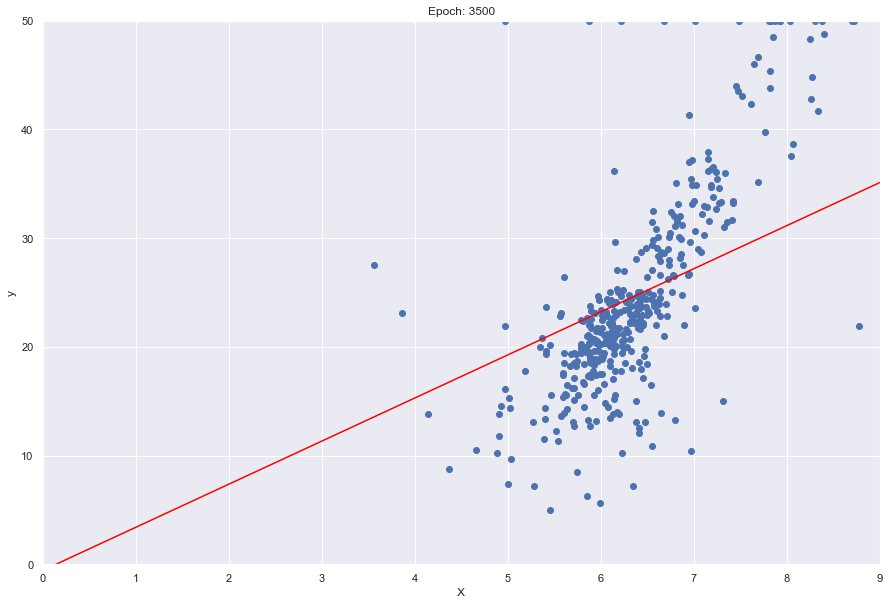

40.60271959621669 7.130538950956668 -20.772181913870565
53.78600479234116 3.963921781322732 -0.5540485220820562
epoch:  4000 average loss:  53.09629351626299
Momentum leader: gradient_w2 = -13.517482727276732, gradient_b2 = -0.7674699239058564, MAX_w_gradient = 139.98378657527653 and b = 22.92924162937004
Momentum leader: mw1 = 0.0005182220021254588, mb1 = -0.0033257967350058598
Momentum leader: guidance_w2 = 0.9999827145648895, guidance_b2 = 0.9999675143563989
Adam follower: mw2 = 7.220419862014149, mb2 = 0.45622823968540993, sw2 = 0.5213922693854303, sb2 = 0.002083795625741122


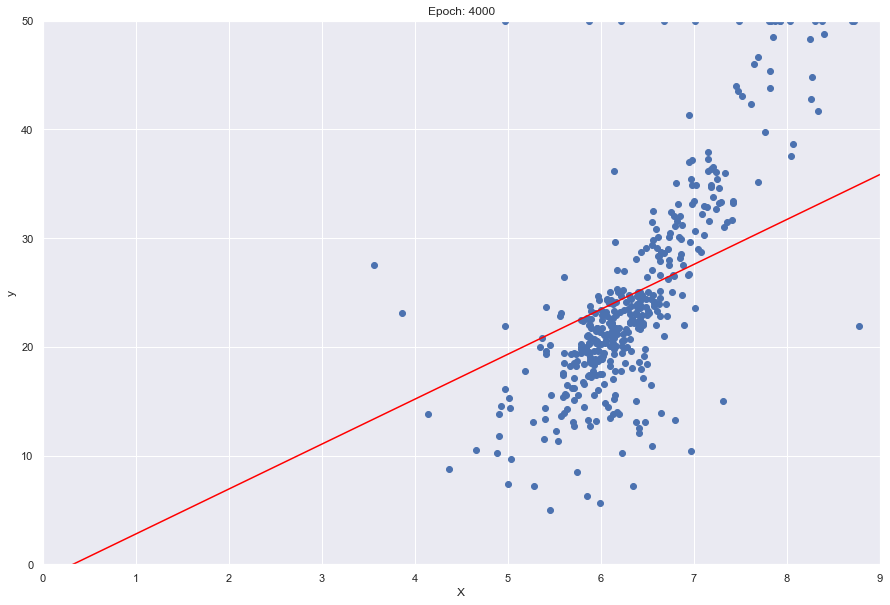

39.95865227404396 7.406974517505496 -22.5462642586894
53.09629351626299 4.1320913698635495 -1.3365955688443445
epoch:  4500 average loss:  52.41672591937476
Momentum leader: gradient_w2 = -45.7648513571651, gradient_b2 = -5.697991118605234, MAX_w_gradient = 139.98378657527653 and b = 22.92924162937004
Momentum leader: mw1 = 0.00045581032256809497, mb1 = -0.0029252568906011096
Momentum leader: guidance_w2 = 0.9999982732966958, guidance_b2 = 0.9999962171487109
Adam follower: mw2 = 23.355855405243243, mb2 = 2.9226368123427964, sw2 = 5.4549598085075175, sb2 = 0.08541805821329018


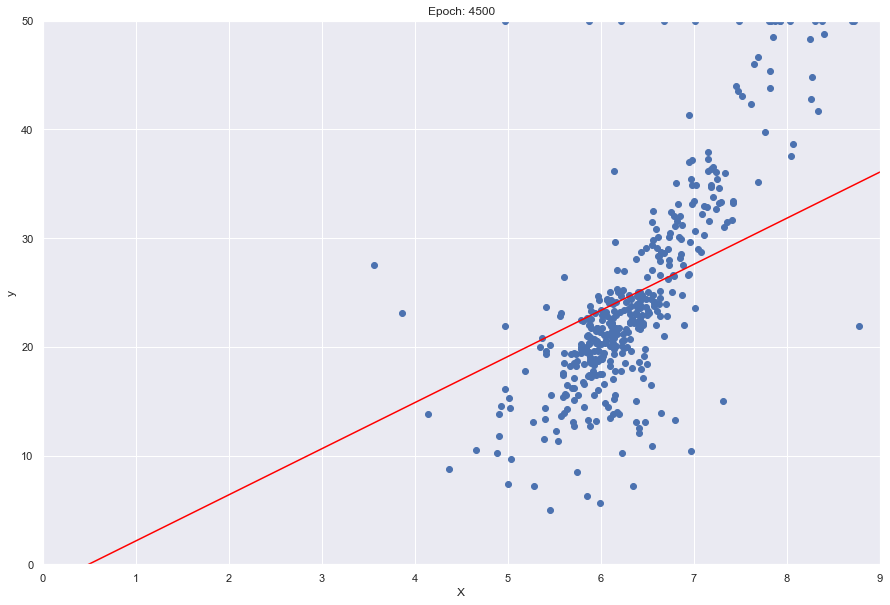

39.46037866912908 7.650117773177959 -24.106686322085856
52.41672591937476 4.240519842838197 -2.0852526293455456
epoch:  5000 average loss:  51.90717740169817
Momentum leader: gradient_w2 = 80.43828390570198, gradient_b2 = 14.131337854148457, MAX_w_gradient = 139.98378657527653 and b = 22.92924162937004
Momentum leader: mw1 = 0.0004009151469973501, mb1 = -0.0025729557630329533
Momentum leader: guidance_w2 = 0.9857890547267165, guidance_b2 = 0.9784413862969821
Adam follower: mw2 = -40.619127016726885, mb2 = -7.1313949233644545, sw2 = 16.506392389525192, sb2 = 0.5090122311005053


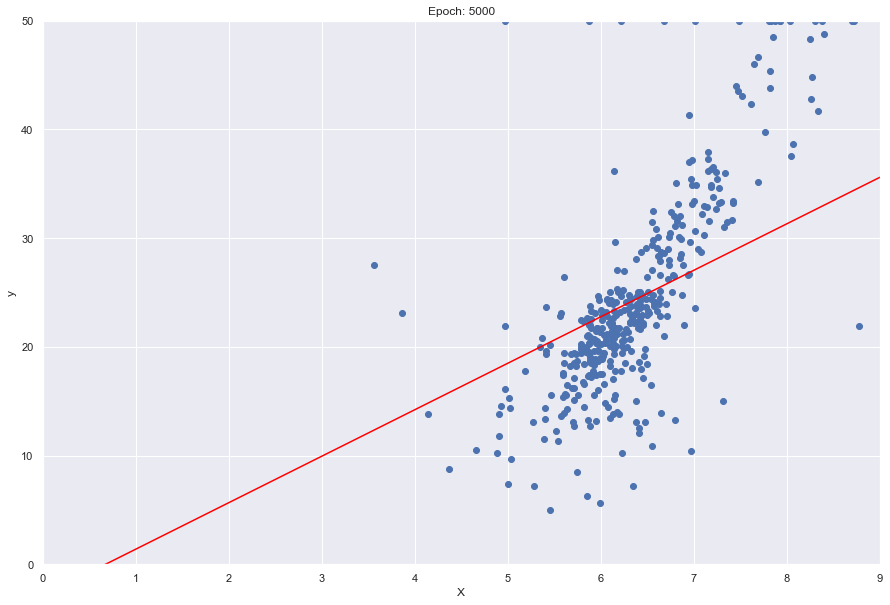

39.074896318437354 7.863978252555039 -25.479180120384243
51.90717740169817 4.274921672645559 -2.8748280687711714
epoch:  5500 average loss:  51.08147597122484
Momentum leader: gradient_w2 = -84.5785214428959, gradient_b2 = -11.408829061933174, MAX_w_gradient = 139.98378657527653 and b = 22.92924162937004
Momentum leader: mw1 = 0.00035263123087408824, mb1 = -0.0022630837584878692
Momentum leader: guidance_w2 = 0.9999998920958698, guidance_b2 = 0.9999996865631271
Adam follower: mw2 = 42.739183513745836, mb2 = 5.772744811241852, sw2 = 18.280457424403853, sb2 = 0.33374093879115324


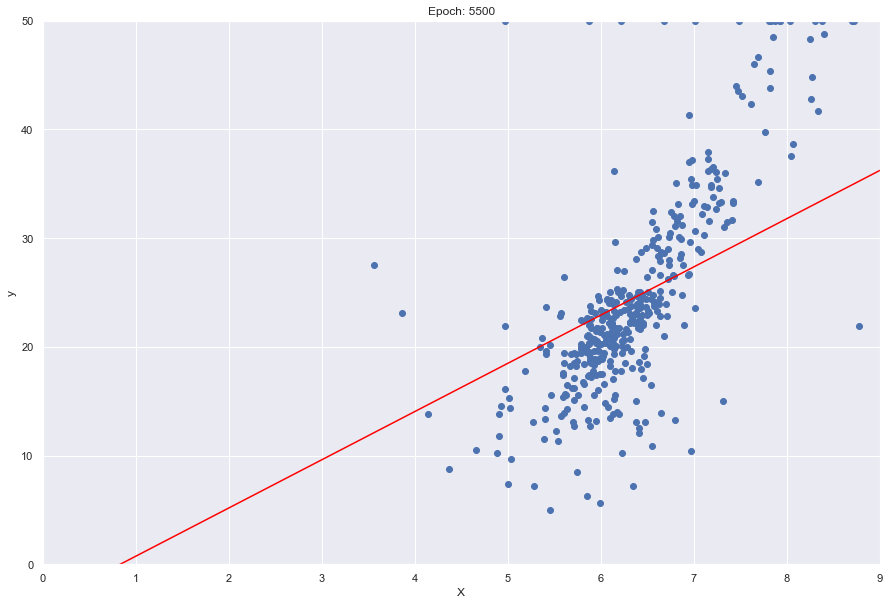

38.7766733316504 8.052082604916771 -26.68637865375239
51.08147597122484 4.43504662170952 -3.6823528351799912
epoch:  6000 average loss:  50.36502993517517
Momentum leader: gradient_w2 = -13.098699997453606, gradient_b2 = 0.3938149708302565, MAX_w_gradient = 139.98378657527653 and b = 22.92924162937004
Momentum leader: mw1 = 0.0003101623521061173, mb1 = -0.0019905309572421388
Momentum leader: guidance_w2 = 0.9999821896319483, guidance_b2 = 0.9999460928648986
Adam follower: mw2 = 6.887888765284894, mb2 = -0.14398044787871642, sw2 = 0.4745118813515029, sb2 = 0.00020711502061443644


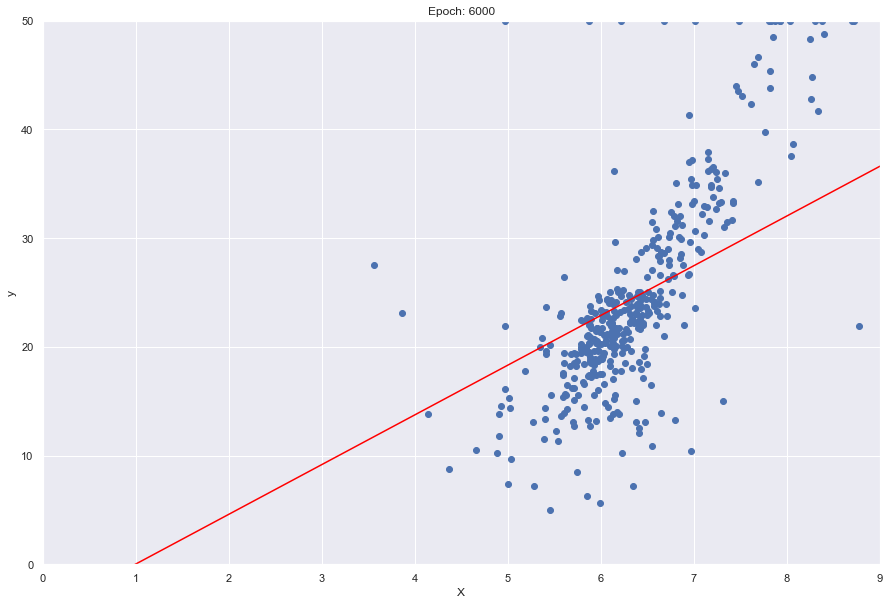

38.54595732172534 8.21753275017265 -27.74818913389666
50.36502993517517 4.572705798911345 -4.539533177372111
epoch:  6500 average loss:  49.70678188574975
Momentum leader: gradient_w2 = 20.813105723765077, gradient_b2 = 3.419484730092761, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 0.0002728081810153252, mb1 = -0.0017508028489351144
Momentum leader: guidance_w2 = 0.9998237427163604, guidance_b2 = 0.999828255739112
Adam follower: mw2 = -10.914480990715274, mb2 = -1.786220211893847, sw2 = 1.1905764998810615, sb2 = 0.03188950629876951


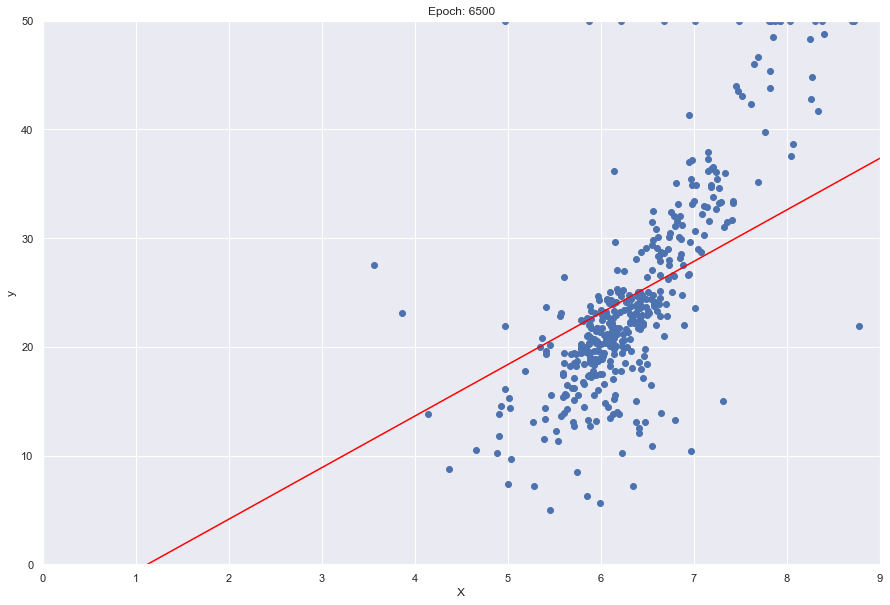

38.36746713285946 8.36305703082592 -28.682121262358212
49.70678188574975 4.7418197872207335 -5.328373646069621
epoch:  7000 average loss:  49.075340856121876
Momentum leader: gradient_w2 = 31.660607472739986, gradient_b2 = 5.905148901567449, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 0.0002399527316042865, mb1 = -0.001539946216202788
Momentum leader: guidance_w2 = 0.999642584330729, guidance_b2 = 0.9995482360221521
Adam follower: mw2 = -16.272783323638706, mb2 = -3.0238455645202893, sw2 = 2.6483392282158698, sb2 = 0.09144933210963908


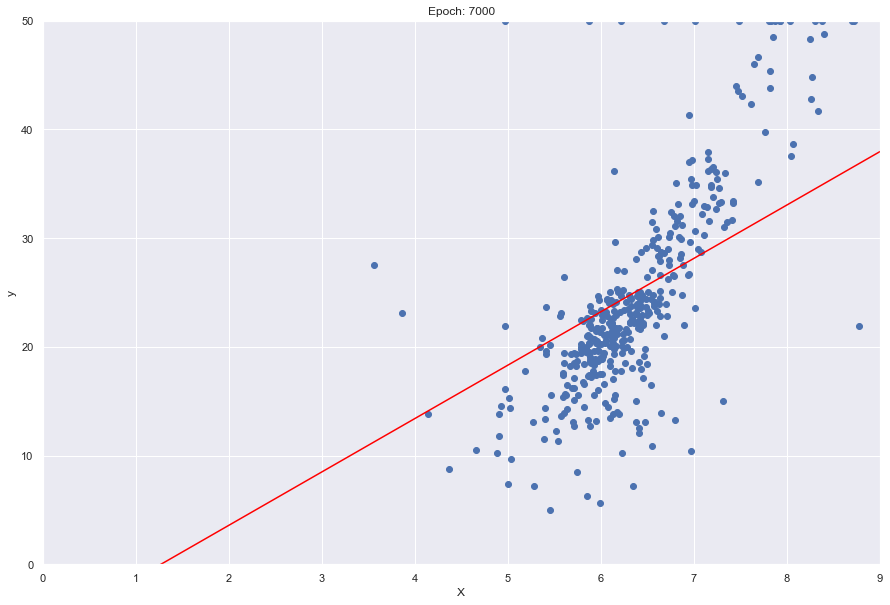

38.22938071427189 8.49105520348934 -29.503575972858155
49.075340856121876 4.9097034225793434 -6.226602917205915
epoch:  7500 average loss:  48.526928238134346
Momentum leader: gradient_w2 = 8.43437310311426, gradient_b2 = 2.4889274405406865, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 0.0002110542036906485, mb1 = -0.0013544839444598234
Momentum leader: guidance_w2 = 0.9999213351417489, guidance_b2 = 0.9998804262151733
Adam follower: mw2 = -4.692581105734679, mb2 = -1.3188100179263784, sw2 = 0.22014007334322844, sb2 = 0.017376361080807756


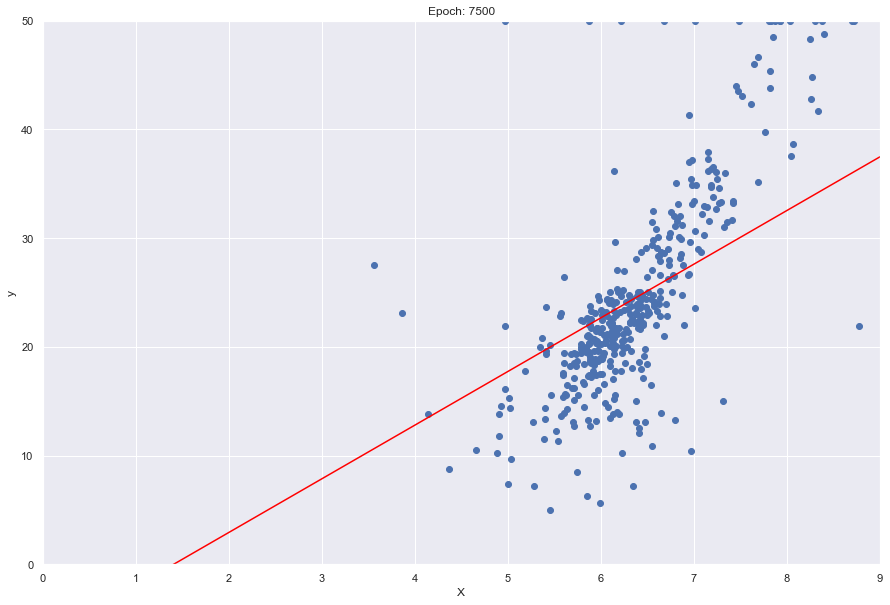

38.12255210302157 8.603638011881387 -30.22609939917411
48.526928238134346 4.934886868087411 -6.934468654043267
epoch:  8000 average loss:  47.84889523753773
Momentum leader: gradient_w2 = -18.924667933781603, gradient_b2 = -1.2384148427114239, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 0.00018563604839094626, mb1 = -0.001191357682817748
Momentum leader: guidance_w2 = 0.9999867744595545, guidance_b2 = 0.9999719594242124
Adam follower: mw2 = 9.908456819379246, mb2 = 0.6872704603477306, sw2 = 0.9865311811899998, sb2 = 0.004794743826114413


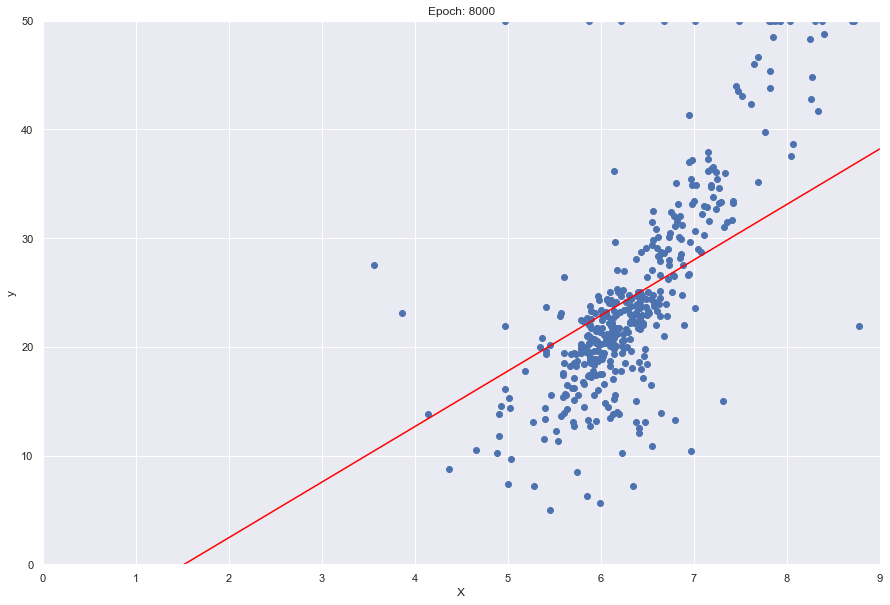

38.03990565380227 8.70266199387813 -30.861606256585127
47.84889523753773 5.108702865616156 -7.761670447798302
epoch:  8500 average loss:  47.62508497715785
Momentum leader: gradient_w2 = -12.979059529696102, gradient_b2 = -1.1208044863974966, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 0.00016327910962911477, mb1 = -0.0010478774105919934
Momentum leader: guidance_w2 = 0.999980515140222, guidance_b2 = 0.9999706464378381
Adam follower: mw2 = 6.5861261097598165, mb2 = 0.5594432634036642, sw2 = 0.4804619539859006, sb2 = 0.003963187698041376


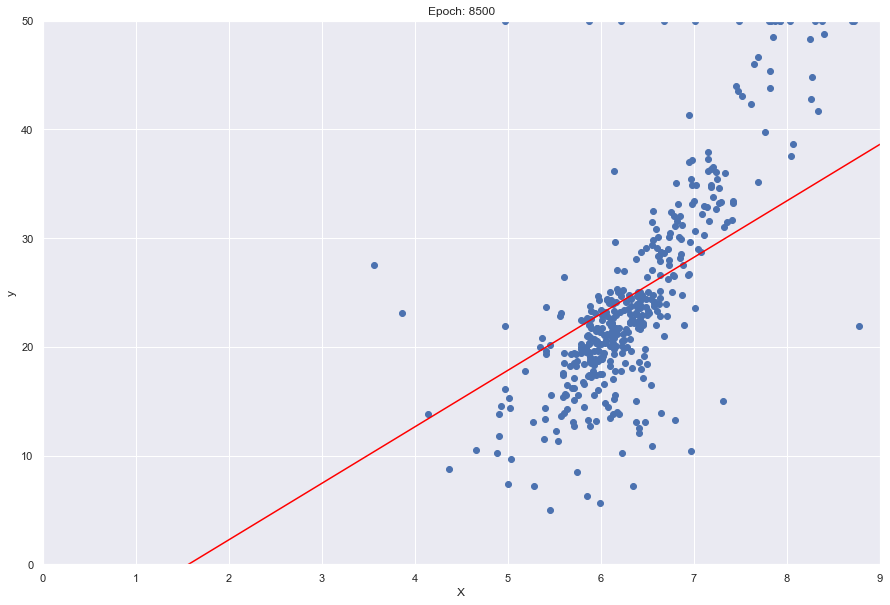

37.97596739336237 8.789760096603949 -31.42057632053961
47.62508497715785 5.195677009484828 -8.132720929829517
epoch:  9000 average loss:  51.94774452754602
Momentum leader: gradient_w2 = -156.84395121782697, gradient_b2 = -25.41888693136046, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 0.00014361471207970946, mb1 = -0.0009216770777286012
Momentum leader: guidance_w2 = 0.9999999983489472, guidance_b2 = 0.9999999976998671
Adam follower: mw2 = 78.86397141848428, mb2 = 12.78082098420176, sw2 = 62.195273350009685, sb2 = 1.6334950078845984


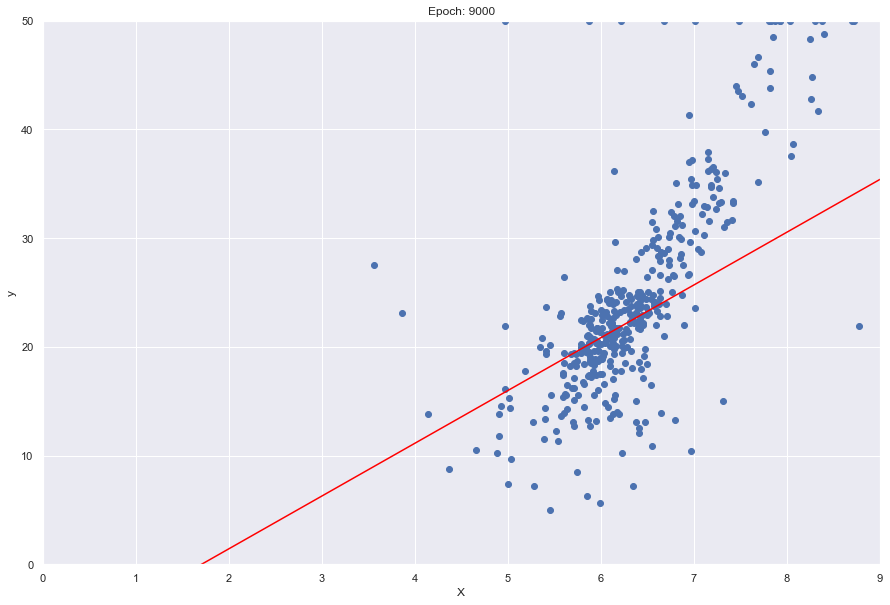

37.926502459457794 8.8663686044166 -31.91222724256137
51.94774452754602 4.853202823116819 -8.275950491660943
epoch:  9500 average loss:  47.15585357731014
Momentum leader: gradient_w2 = 38.65630767225224, gradient_b2 = 7.642816659859538, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 0.00012631858155381898, mb1 = -0.0008106755876438338
Momentum leader: guidance_w2 = 0.9994361298176329, guidance_b2 = 0.9991117320784573
Adam follower: mw2 = -19.7581658539336, mb2 = -3.8942617387508727, sw2 = 3.89932161565656, sb2 = 0.15139536581818744


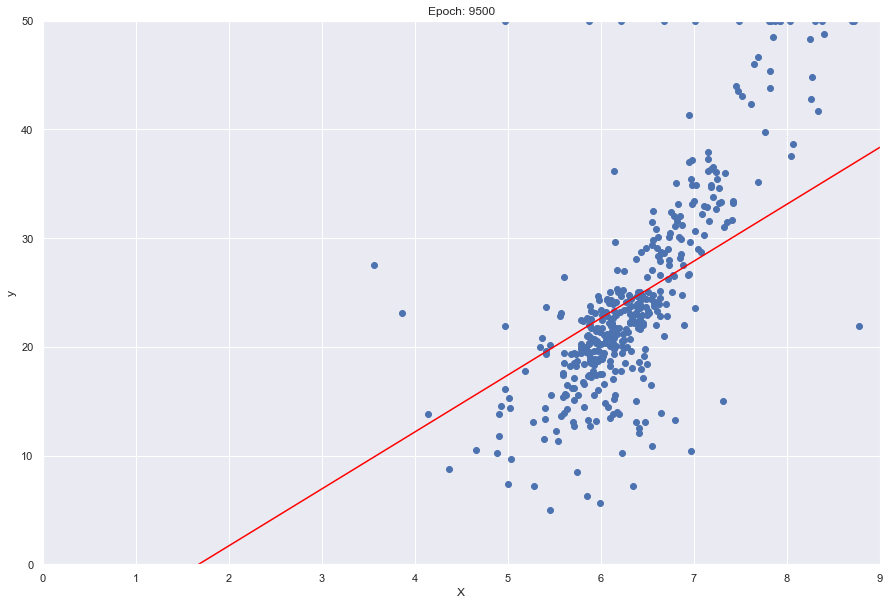

37.88823461060878 8.933750823840542 -32.34466655320126
47.15585357731014 5.236083562032505 -8.766829690498495
epoch:  10000 average loss:  47.48557558678018
Momentum leader: gradient_w2 = -67.24856964802241, gradient_b2 = -11.029369607425549, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 0.00011110549758259482, mb1 = -0.0007130424790657173
Momentum leader: guidance_w2 = 0.9999994329009184, guidance_b2 = 0.9999993786959738
Adam follower: mw2 = 34.105707175908925, mb2 = 5.58879902408493, sw2 = 11.63199343132366, sb2 = 0.3123473452719711


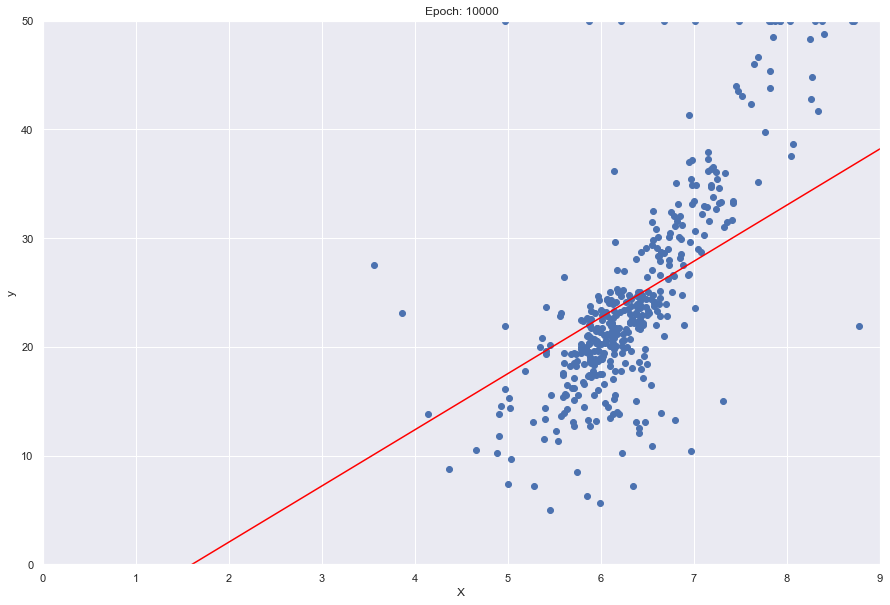

37.85862922877691 8.993017916023055 -32.72502535862717
47.48557558678018 5.166435359337554 -8.287810561025697
epoch:  10500 average loss:  47.04387970584546
Momentum leader: gradient_w2 = -21.67573695003965, gradient_b2 = -1.8311287874323563, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 9.772459001033073e-05, mb1 = -0.0006271677409578008
Momentum leader: guidance_w2 = 0.9999889452870946, guidance_b2 = 0.9999777346417369
Adam follower: mw2 = 11.311454850188019, mb2 = 0.9891854647644313, sw2 = 1.2794898878464207, sb2 = 0.00978486205874319


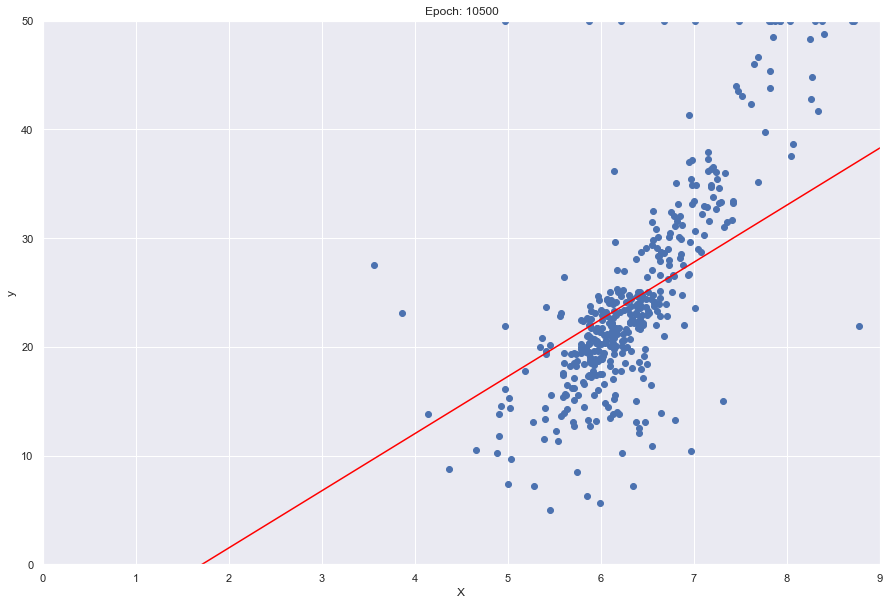

37.83572544244527 9.045147220249003 -33.05957593556465
47.04387970584546 5.254469558290939 -8.993060096958624
epoch:  11000 average loss:  46.15751207736455
Momentum leader: gradient_w2 = 33.23610287241105, gradient_b2 = 5.346054064731369, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 8.595520204270665e-05, mb1 = -0.0005516352627594278
Momentum leader: guidance_w2 = 0.9996039352063318, guidance_b2 = 0.9996365578099741
Adam follower: mw2 = -17.05335395603776, mb2 = -2.7440356166134157, sw2 = 2.908445921975862, sb2 = 0.07530374198984698


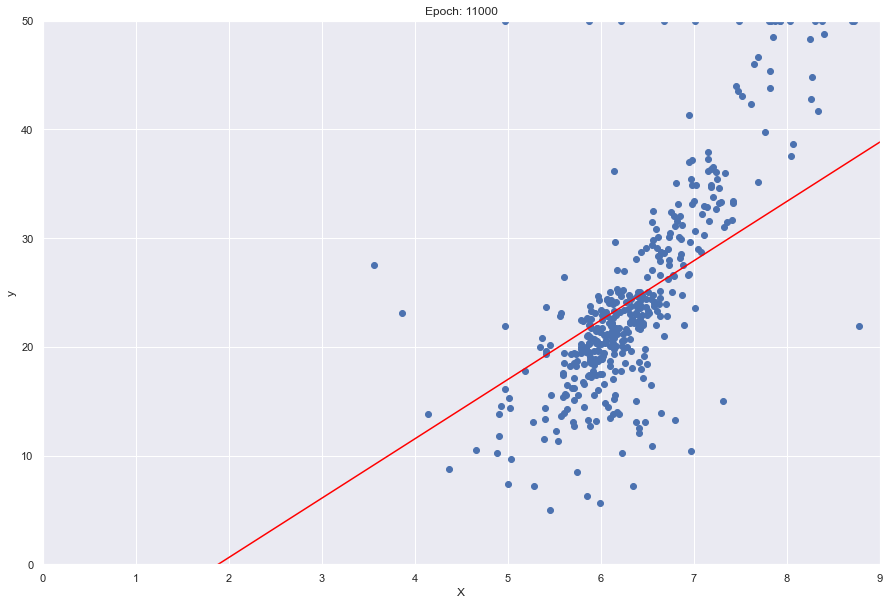

37.818006251005514 9.09099837067684 -33.353835163778996
46.15751207736455 5.458699960497433 -10.286626537232705
epoch:  11500 average loss:  46.52129338430797
Momentum leader: gradient_w2 = 42.816798620838455, gradient_b2 = 7.886359066821673, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 7.560325151924459e-05, mb1 = -0.0004851994821273244
Momentum leader: guidance_w2 = 0.9992605016401762, guidance_b2 = 0.9990234421979396
Adam follower: mw2 = -21.843023980853058, mb2 = -4.013694237139842, sw2 = 4.77178641115544, sb2 = 0.16113054566159002


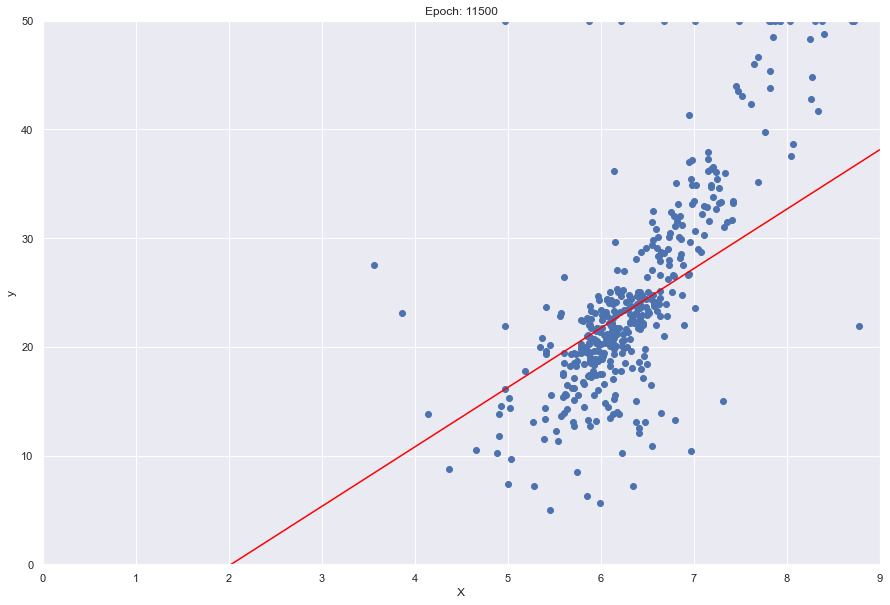

37.80429804832094 9.131327472067582 -33.612655501744044
46.52129338430797 5.4679884240859815 -11.06772313885123
epoch:  12000 average loss:  45.186271251966225
Momentum leader: gradient_w2 = 71.04790975400248, gradient_b2 = 12.179766966093977, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 6.649803042059128e-05, mb1 = -0.00042676484508807845
Momentum leader: guidance_w2 = 0.9953442727567055, guidance_b2 = 0.9948095956962303
Adam follower: mw2 = -35.950989113919675, mb2 = -6.159576881071471, sw2 = 12.927990061319488, sb2 = 0.37952427725932925


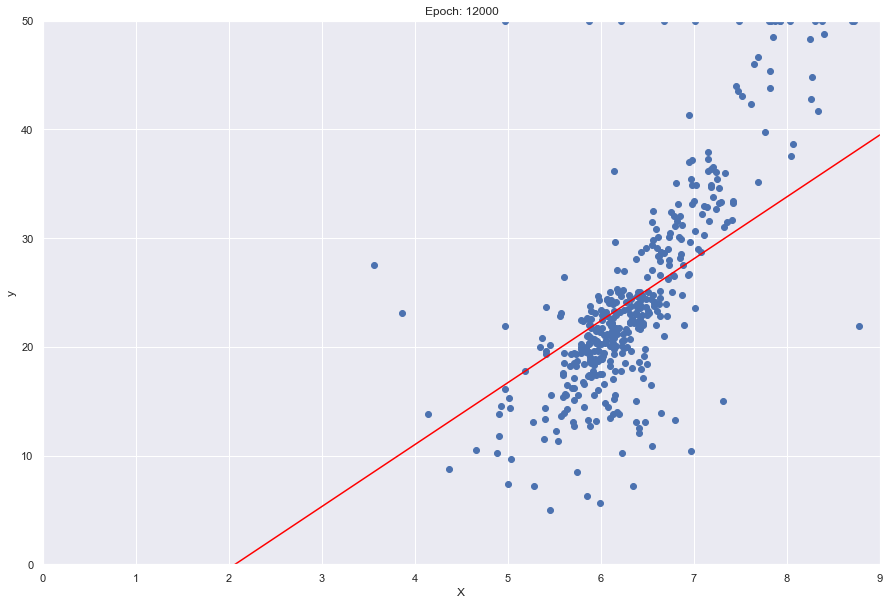

37.79369289054719 9.166799568270378 -33.84030500572339
45.186271251966225 5.6963943206843295 -11.769067915380422
epoch:  12500 average loss:  45.19101322923088
Momentum leader: gradient_w2 = -28.66219402214853, gradient_b2 = -3.438094448374139, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 5.8489389820848746e-05, mb1 = -0.0003753677398922885
Momentum leader: guidance_w2 = 0.9999929886193867, guidance_b2 = 0.9999880852908654
Adam follower: mw2 = 14.851603786962121, mb2 = 1.7958823413173073, sw2 = 2.20660031626094, sb2 = 0.03226915289179263


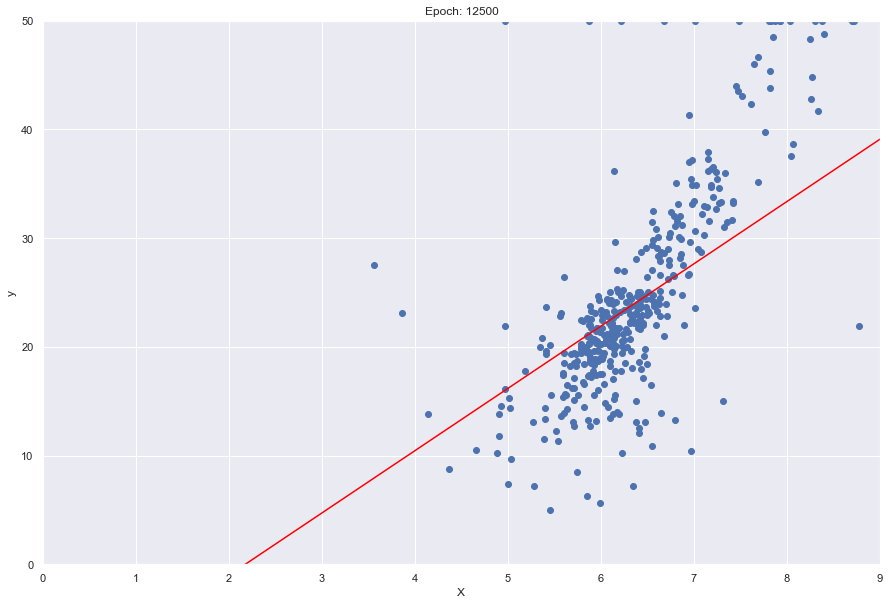

37.78548835972767 9.197999609075362 -34.04053771181397
45.19101322923088 5.729075530777918 -12.462926352526537
epoch:  13000 average loss:  44.36497020788946
Momentum leader: gradient_w2 = 5.377692572179543, gradient_b2 = 2.825196736459959, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 5.144526386791284e-05, mb1 = -0.0003301606066514299
Momentum leader: guidance_w2 = 0.9999355437834809, guidance_b2 = 0.9998637115633766
Adam follower: mw2 = -3.1814026498393244, mb2 = -1.4875505485842127, sw2 = 0.10121387417930025, sb2 = 0.02212820763363988


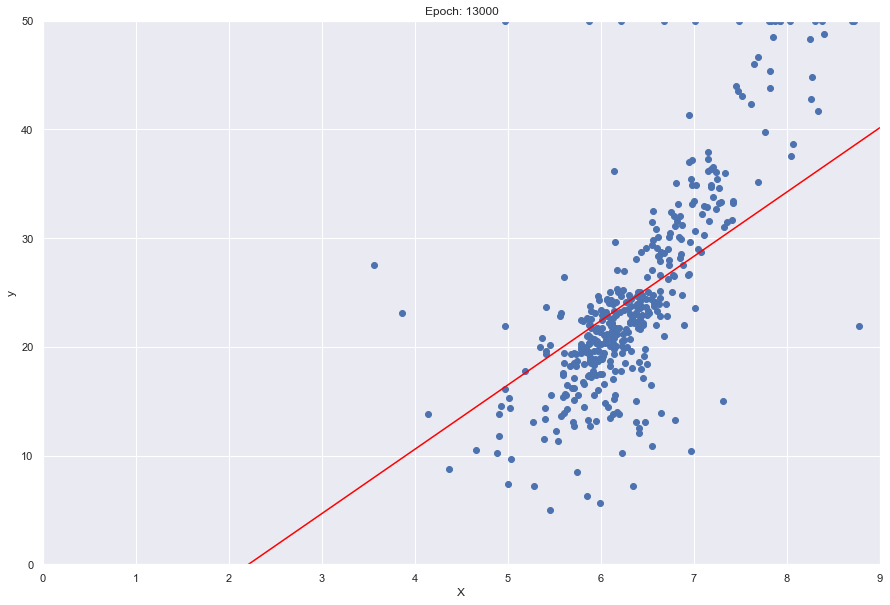

37.779141040111625 9.225442096281848 -34.216655541580785
44.36497020788946 5.915267676088411 -13.074391997360856
epoch:  13500 average loss:  44.422658374549854
Momentum leader: gradient_w2 = -20.101799280372045, gradient_b2 = -2.6640699364766585, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 4.524949195883758e-05, mb1 = -0.0002903979607192234
Momentum leader: guidance_w2 = 0.9999877511298775, guidance_b2 = 0.9999838980424365
Adam follower: mw2 = 10.481274907814875, mb2 = 1.4025463710324553, sw2 = 1.098563970146109, sb2 = 0.019671316469175727


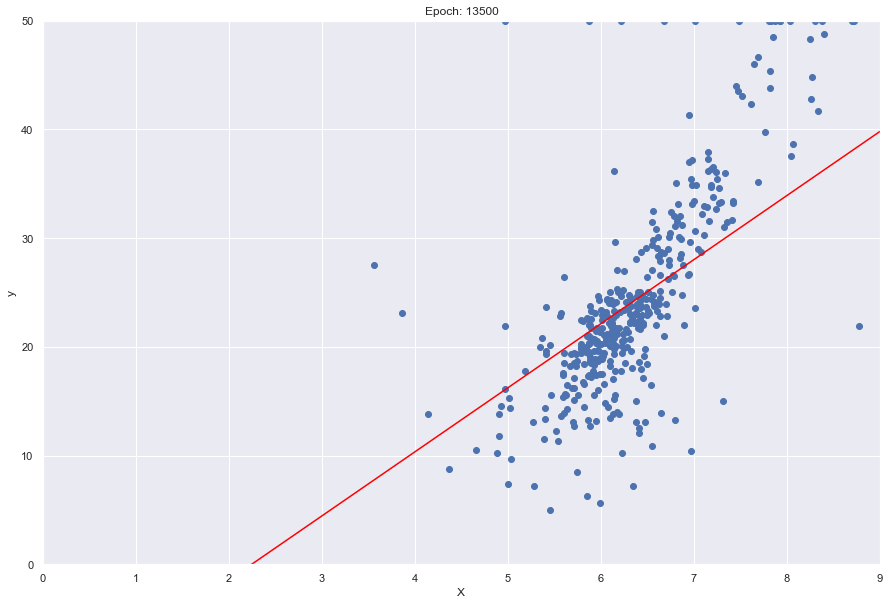

37.774230525763556 9.249579568049455 -34.371562752132924
44.422658374549854 5.893430456877477 -13.226029434829362
epoch:  14000 average loss:  44.52506930311128
Momentum leader: gradient_w2 = -54.580297644861396, gradient_b2 = -6.717073697575994, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 3.9799903209969506e-05, mb1 = -0.00025542409933504944
Momentum leader: guidance_w2 = 0.9999987051473688, guidance_b2 = 0.9999966734112677
Adam follower: mw2 = 27.765409496691593, mb2 = 3.432192585270216, sw2 = 7.709975916834005, sb2 = 0.1178170943579506


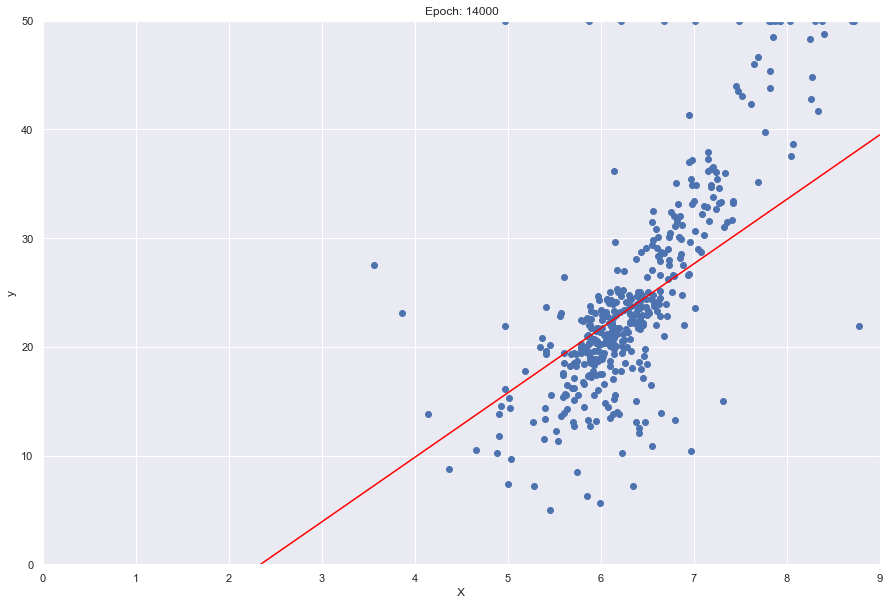

37.77043157555767 9.270810061442736 -34.50781382854485
44.52506930311128 5.93289533128743 -13.883796960733953
epoch:  14500 average loss:  43.562722986213025
Momentum leader: gradient_w2 = -12.196916049192657, gradient_b2 = -3.353883356253821, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 3.5006631609440425e-05, mb1 = -0.0002246622888106618
Momentum leader: guidance_w2 = 0.999979496170152, guidance_b2 = 0.9999876884283428
Adam follower: mw2 = 6.560253101771175, mb2 = 1.7494496187399782, sw2 = 0.43037075100107747, sb2 = 0.030607676252281397


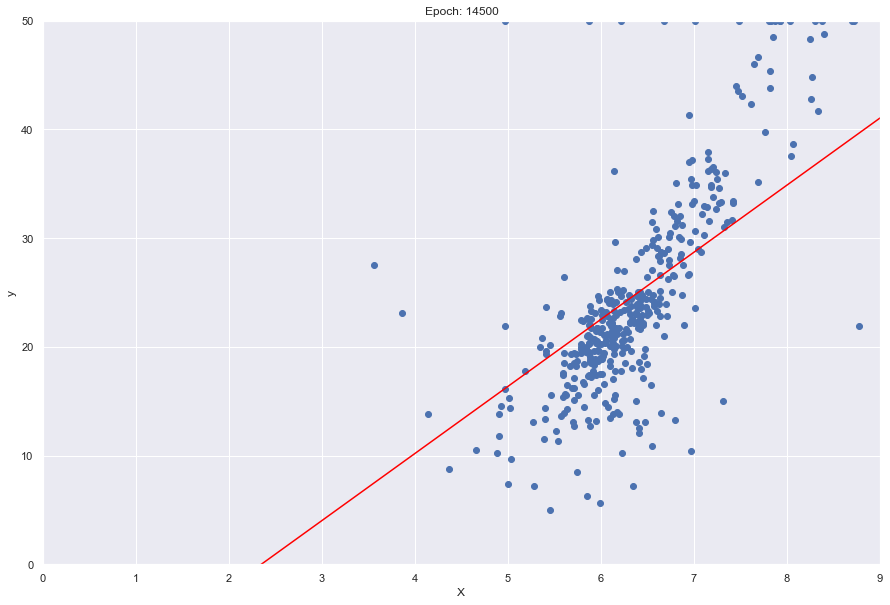

37.76749257128152 9.289483676229791 -34.62765560838979
43.562722986213025 6.1701946513321255 -14.48580635814999
epoch:  15000 average loss:  43.56100979374888
Momentum leader: gradient_w2 = -16.68698460686598, gradient_b2 = -0.1425391502533543, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 3.0790634091764076e-05, mb1 = -0.00019760525394845333
Momentum leader: guidance_w2 = 0.9999846979867149, guidance_b2 = 0.9999570494420216
Adam follower: mw2 = 8.817467565498449, mb2 = 0.14463850829171593, sw2 = 0.7777396568356931, sb2 = 0.00021008669063801415


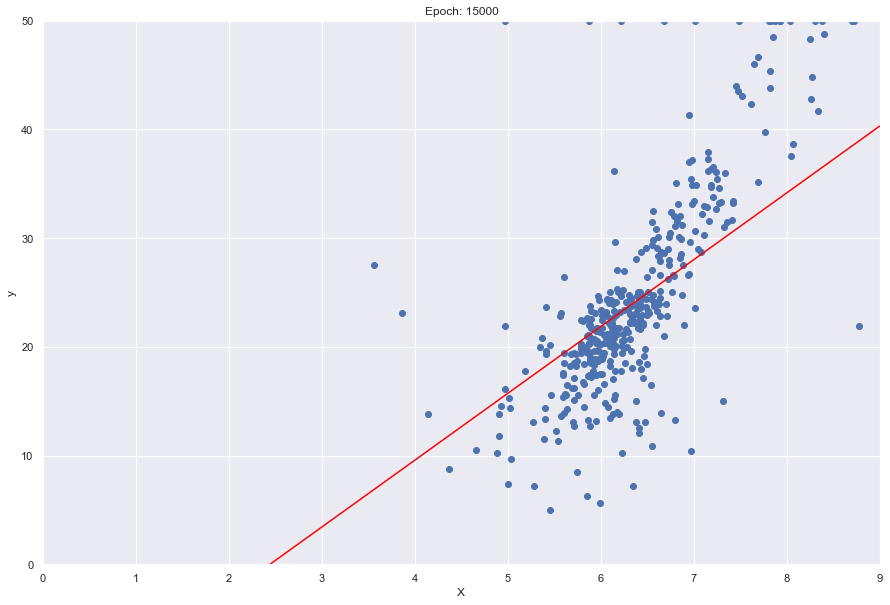

37.765218852051994 9.305908348174802 -34.73306433303717
43.56100979374888 6.147959832812618 -15.00652126140945
epoch:  15500 average loss:  43.04756224283821
Momentum leader: gradient_w2 = 33.640795608489405, gradient_b2 = 1.8145482681771854, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 2.7082387084919445e-05, mb1 = -0.0001738068128600606
Momentum leader: guidance_w2 = 0.9995933501476576, guidance_b2 = 0.9999080230750093
Adam follower: mw2 = -17.221531384838574, mb2 = -0.9752092786213066, sw2 = 2.9658315640254624, sb2 = 0.009510479696192524


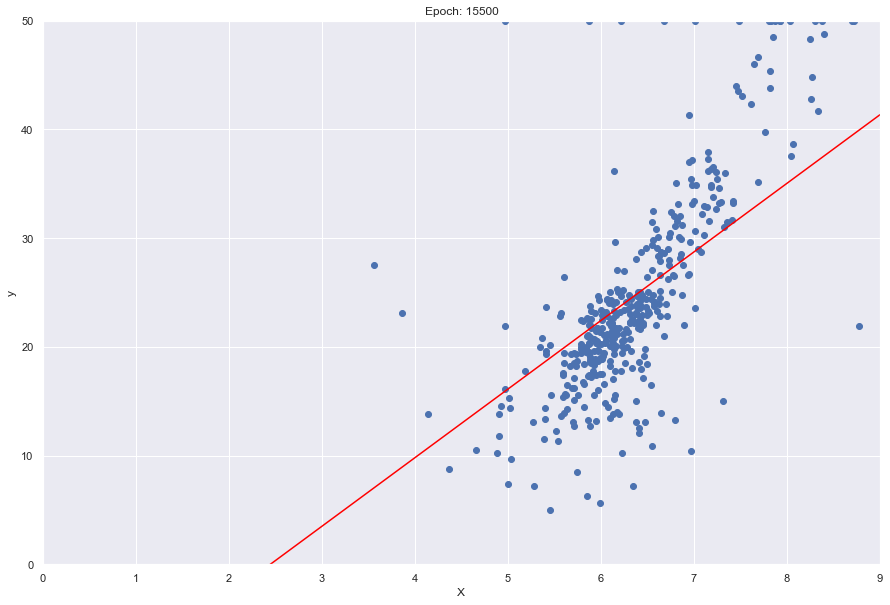

37.76345982122083 9.320354927028294 -34.82577823670371
43.04756224283821 6.308246628683595 -15.424489707075383
epoch:  16000 average loss:  42.98235900825348
Momentum leader: gradient_w2 = -58.098618190740034, gradient_b2 = -6.386522114459942, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 2.382074003487845e-05, mb1 = -0.00015287451923952158
Momentum leader: guidance_w2 = 0.9999989704719595, guidance_b2 = 0.9999962168290819
Adam follower: mw2 = 29.529283467256818, mb2 = 3.267323191029454, sw2 = 8.719880616258935, sb2 = 0.1067561648282627


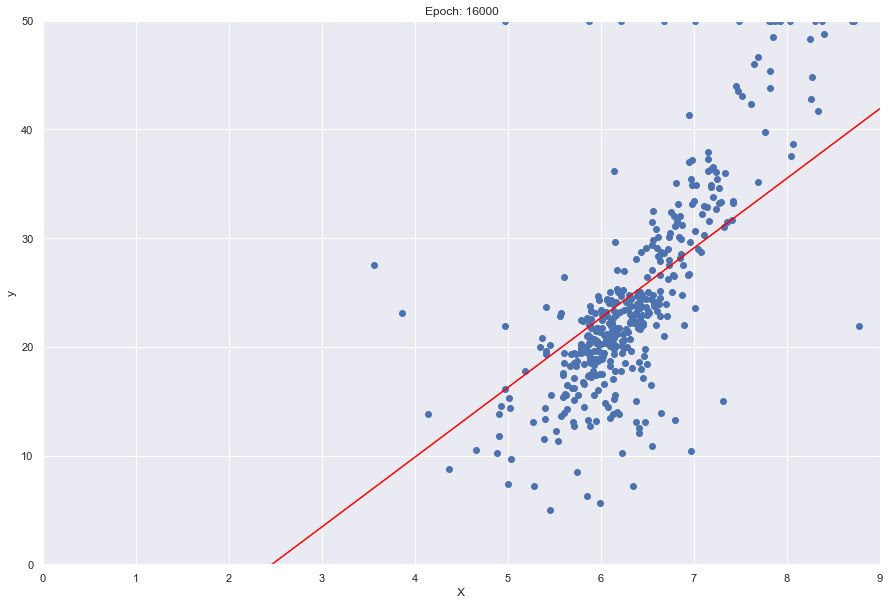

37.7620989718139 9.333061642953547 -34.907326210667605
42.98235900825348 6.412042828608578 -15.791546009009831
epoch:  16500 average loss:  42.90016637378465
Momentum leader: gradient_w2 = 6.006820246587824, gradient_b2 = 1.1680962707129832, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 2.0951907010097752e-05, mb1 = -0.00013446319075837896
Momentum leader: guidance_w2 = 0.9999328460487439, guidance_b2 = 0.9999284777858729
Adam follower: mw2 = -3.6855384635945203, mb2 = -0.693048438206705, sw2 = 0.12032336896605977, sb2 = 0.004351492484471602


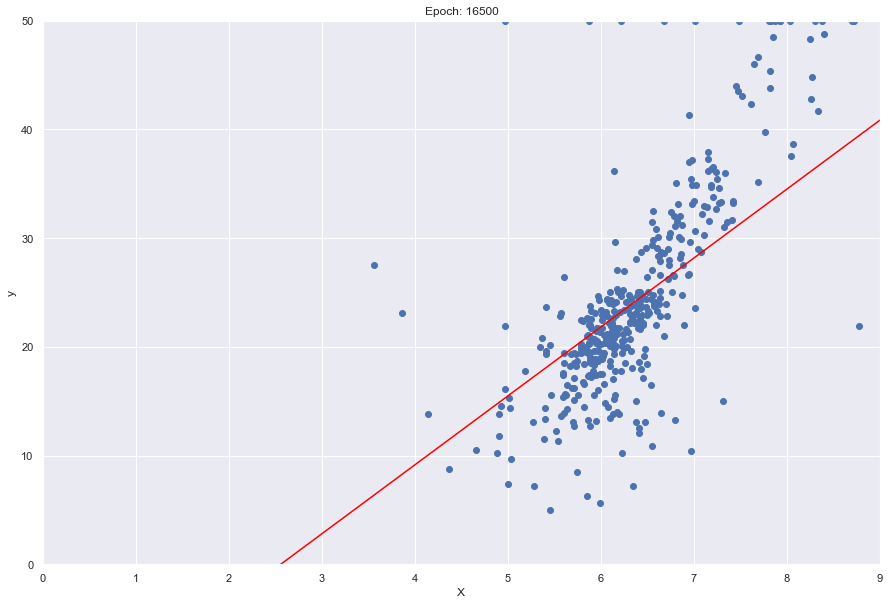

37.76104616985297 9.344238035042109 -34.97905301532821
42.90016637378465 6.340081366792685 -16.20690630935427
epoch:  17000 average loss:  42.459530010937186
Momentum leader: gradient_w2 = -33.85823129456844, gradient_b2 = -2.3350302830384644, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 1.84285797469794e-05, mb1 = -0.00011826921686401191
Momentum leader: guidance_w2 = 0.9999950026994834, guidance_b2 = 0.9999816987800261
Adam follower: mw2 = 17.46046507430456, mb2 = 1.2450154326441667, sw2 = 3.0486842443189532, sb2 = 0.015500455562612465


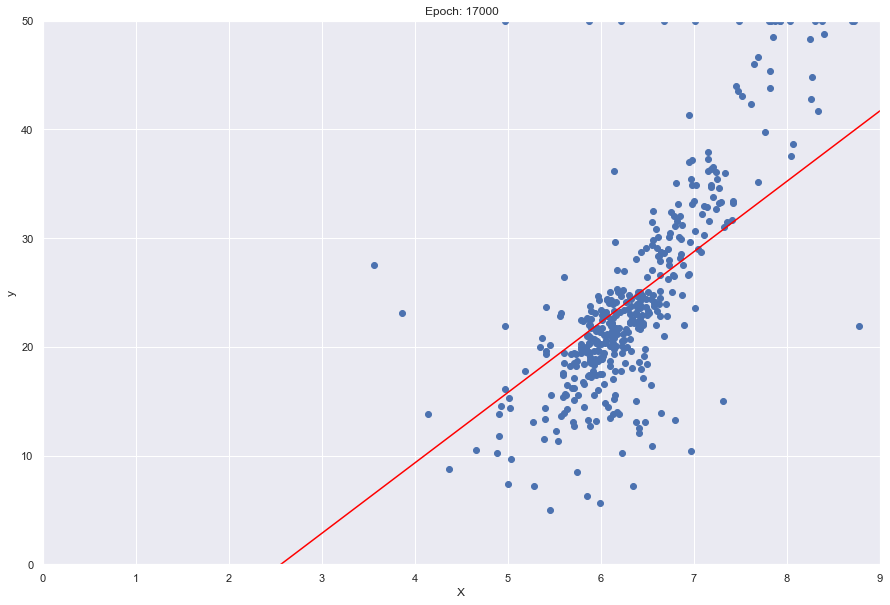

37.76023168445636 9.354068406701622 -35.042141455871075
42.459530010937186 6.474816650991953 -16.566138517974704
epoch:  17500 average loss:  42.48416307506984
Momentum leader: gradient_w2 = 64.50371325771594, gradient_b2 = 10.133695136938732, MAX_w_gradient = 153.4398468684385 and b = 25.700827664267045
Momentum leader: mw1 = 1.6209147517116774e-05, mb1 = -0.00010402555211382118
Momentum leader: guidance_w2 = 0.9969607858691749, guidance_b2 = 0.9976587140380554
Adam follower: mw2 = -32.71145589784472, mb2 = -5.13952723794806, sw2 = 10.700937105556878, sb2 = 0.26416732972381046


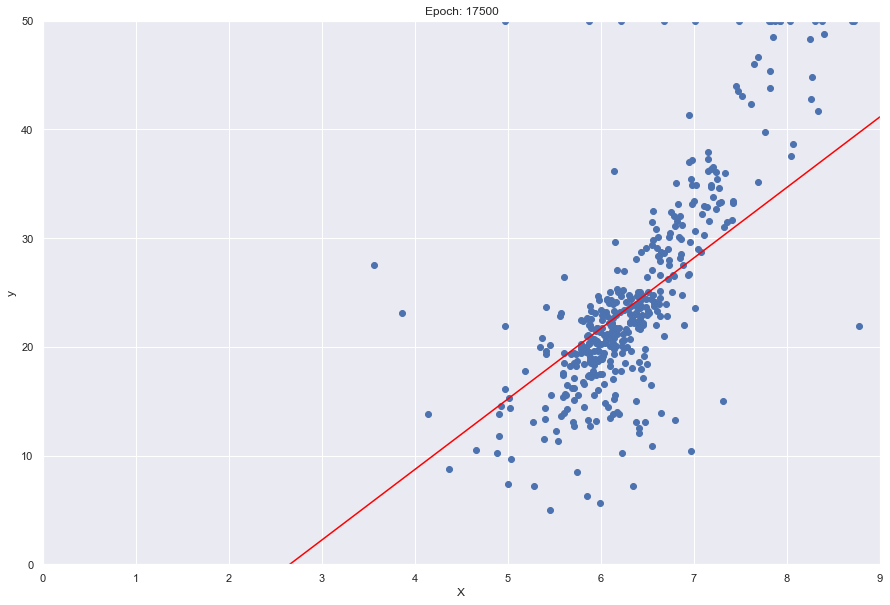

37.75960156931046 9.362714864896576 -35.09763188722327
42.48416307506984 6.48541243913597 -17.21359320569403
epoch:  18000 average loss:  42.120213246167864
Momentum leader: gradient_w2 = 26.447014356218695, gradient_b2 = 4.849411416767023, MAX_w_gradient = 153.86851834912838 and b = 25.700827664267045
Momentum leader: mw1 = 1.4257010948303664e-05, mb1 = -9.149731248363282e-05
Momentum leader: guidance_w2 = 0.9997467653246037, guidance_b2 = 0.9997004203564236
Adam follower: mw2 = -13.684739255568068, mb2 = -2.4974851514209306, sw2 = 1.8729126612154146, sb2 = 0.06238050513387223


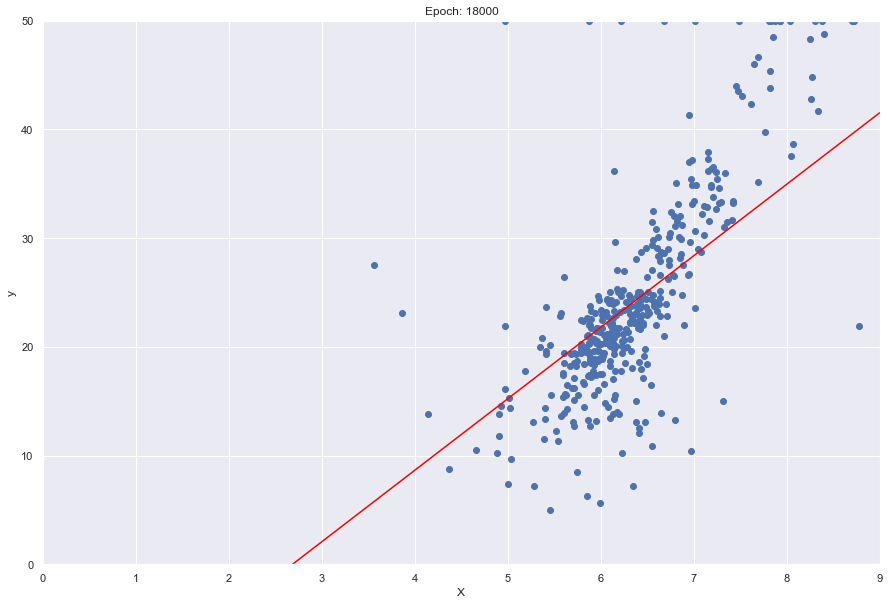

37.75911408961 9.370319993360349 -35.14643936994374
42.120213246167864 6.577620538361457 -17.64838370456677
epoch:  18500 average loss:  41.73257791809022
Momentum leader: gradient_w2 = -22.1928722844737, gradient_b2 = -3.4142248152035046, MAX_w_gradient = 153.86851834912838 and b = 25.700827664267045
Momentum leader: mw1 = 1.2539978489194634e-05, mb1 = -8.047790203080057e-05
Momentum leader: guidance_w2 = 0.9999892684979861, guidance_b2 = 0.9999879741175915
Adam follower: mw2 = 11.551426211004618, mb2 = 1.7791170181443379, sw2 = 1.3348698572036697, sb2 = 0.031674075657404405


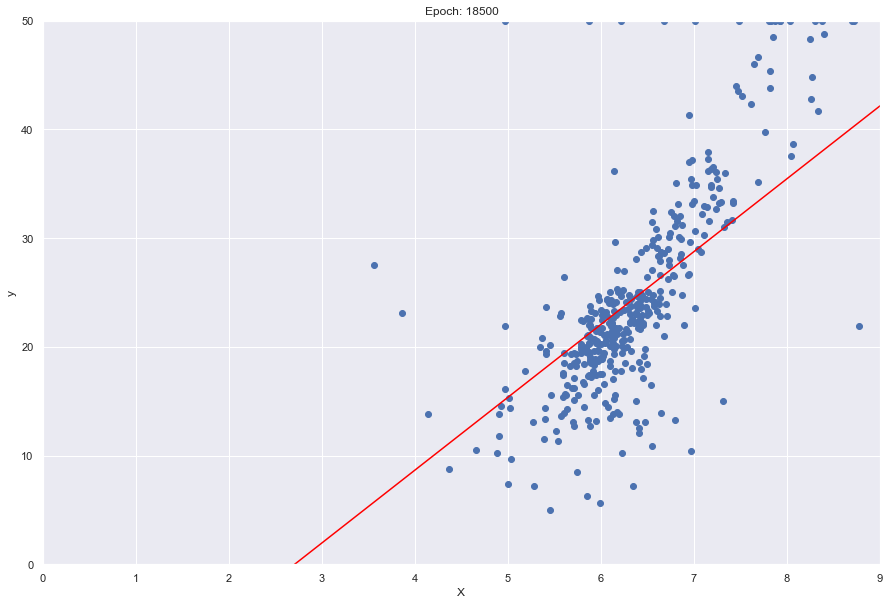

37.758736957811344 9.37700920386091 -35.18936875995668
41.73257791809022 6.69894494882475 -18.129171249202702
epoch:  19000 average loss:  41.50817670161399
Momentum leader: gradient_w2 = -9.52093176422985, gradient_b2 = 0.362630978279878, MAX_w_gradient = 153.86851834912838 and b = 25.700827664267045
Momentum leader: mw1 = 1.1029735551341571e-05, mb1 = -7.07856060410113e-05
Momentum leader: guidance_w2 = 0.999975547317013, guidance_b2 = 0.9999477203307655
Adam follower: mw2 = 5.093216931852651, mb2 = -0.12882415820021947, sw2 = 0.2594021275451005, sb2 = 0.00016601852359527178


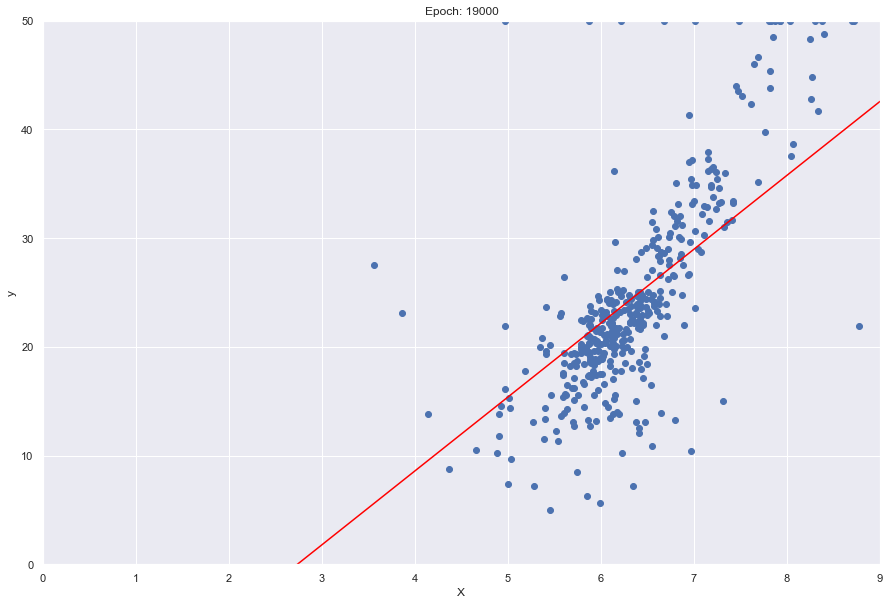

37.75844519511144 9.382892804293688 -35.22712798096458
41.50817670161399 6.7961067809297555 -18.59172099246949
epoch:  19500 average loss:  41.414615138196815
Momentum leader: gradient_w2 = 51.02343969126005, gradient_b2 = 8.475664867103918, MAX_w_gradient = 153.86851834912838 and b = 25.700827664267045
Momentum leader: mw1 = 9.70137759227449e-06, mb1 = -6.226059447579368e-05
Momentum leader: guidance_w2 = 0.9987491831618944, guidance_b2 = 0.998771771182171
Adam follower: mw2 = -25.93318195174839, mb2 = -4.307738784141855, sw2 = 6.725355681646804, sb2 = 0.1855694166860877


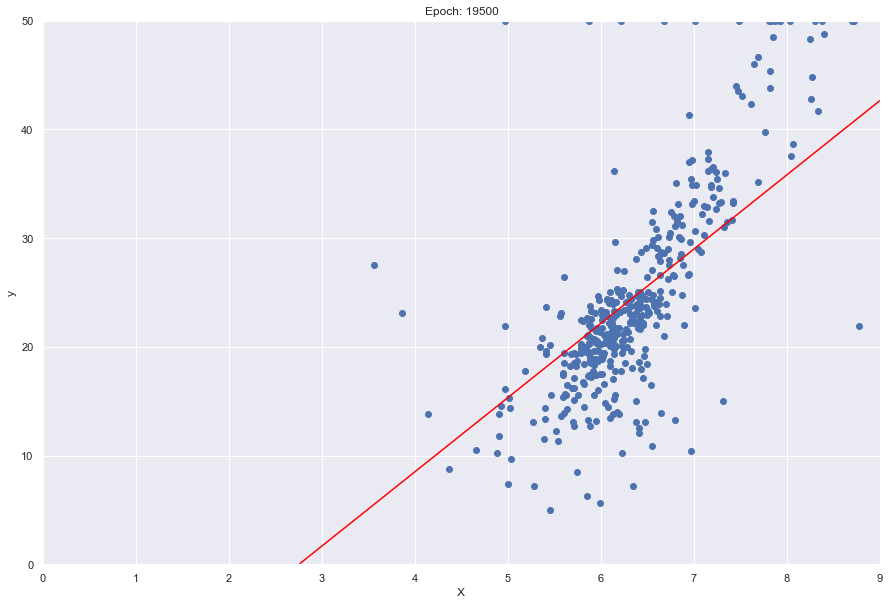

37.758219477011394 9.388067817705181 -35.26033969840799
41.414615138196815 6.828677819690839 -18.803670908528115
epoch:  20000 average loss:  41.280352084458656
Momentum leader: gradient_w2 = -6.740962112840663, gradient_b2 = 0.11178153039192912, MAX_w_gradient = 153.86851834912838 and b = 25.700827664267045
Momentum leader: mw1 = 8.532999432013949e-06, mb1 = -5.476228630757772e-05
Momentum leader: guidance_w2 = 0.9999707051507593, guidance_b2 = 0.9999525819045605
Adam follower: mw2 = 3.8353742992129605, mb2 = 0.017143679977666262, sw2 = 0.14709521908766177, sb2 = 2.9315383946288774e-06


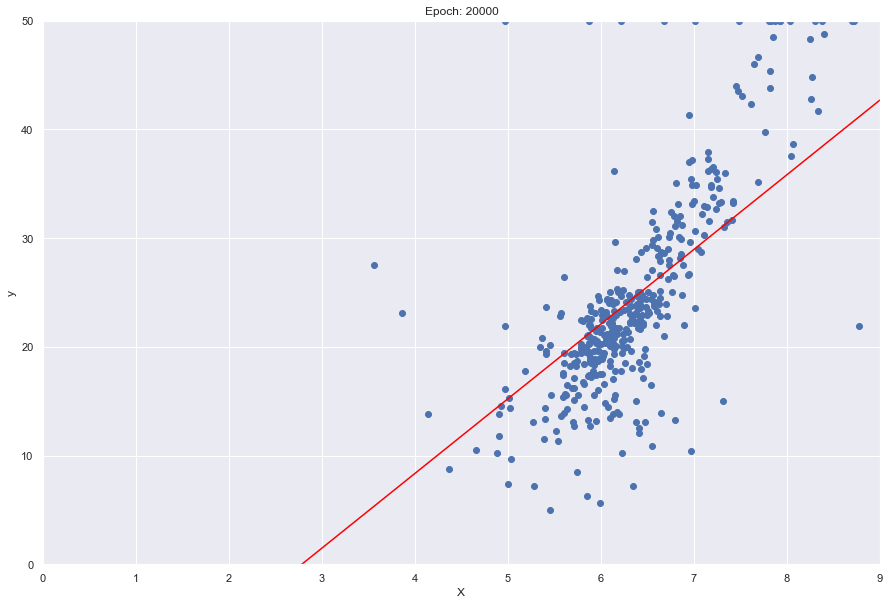

37.75804485338505 9.392619582243752 -35.289551587480254
41.280352084458656 6.868176407391219 -19.113704564600223
epoch:  20500 average loss:  41.08714712662003
Momentum leader: gradient_w2 = -43.71654203017947, gradient_b2 = -4.5235084751025605, MAX_w_gradient = 153.86851834912838 and b = 25.700827664267045
Momentum leader: mw1 = 7.505334021993146e-06, mb1 = -4.816703128014661e-05
Momentum leader: guidance_w2 = 0.9999973505598762, guidance_b2 = 0.9999921896700406
Adam follower: mw2 = 22.357960524979347, mb2 = 2.336863155381229, sw2 = 4.998782383843372, sb2 = 0.05460918121142059


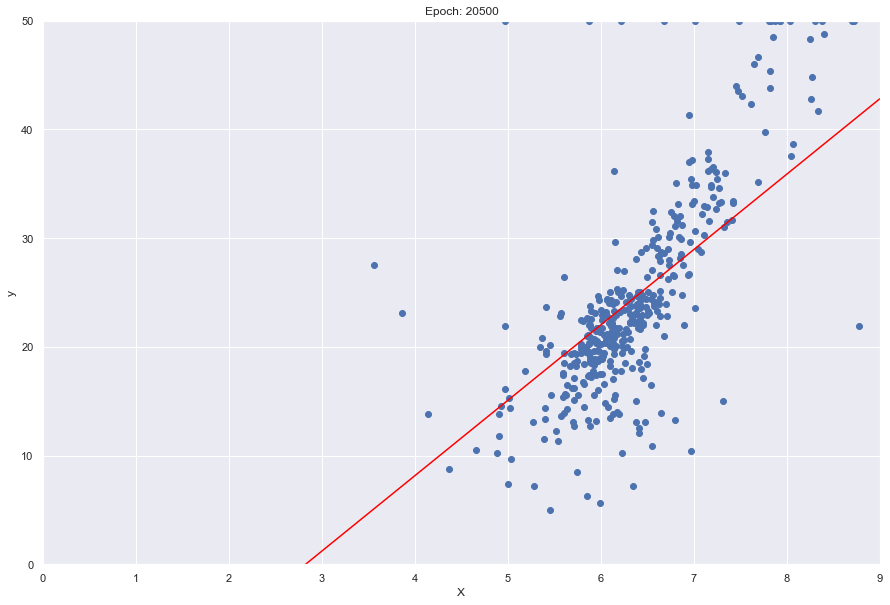

37.757909758278046 9.396623158421665 -35.31524536452222
41.08714712662003 6.934232053496302 -19.57979735686147
epoch:  21000 average loss:  43.934437853536565
Momentum leader: gradient_w2 = 0.8192144649582225, gradient_b2 = 0.1210556433737717, MAX_w_gradient = 153.86851834912838 and b = 25.700827664267045
Momentum leader: mw1 = 6.601434727595184e-06, mb1 = -4.236607086329137e-05
Momentum leader: guidance_w2 = 0.9999521174202585, guidance_b2 = 0.9999524104878376
Adam follower: mw2 = -0.8827775620296793, mb2 = -0.13442776237865273, sw2 = 0.007788933754839996, sb2 = 0.00018047942314834705


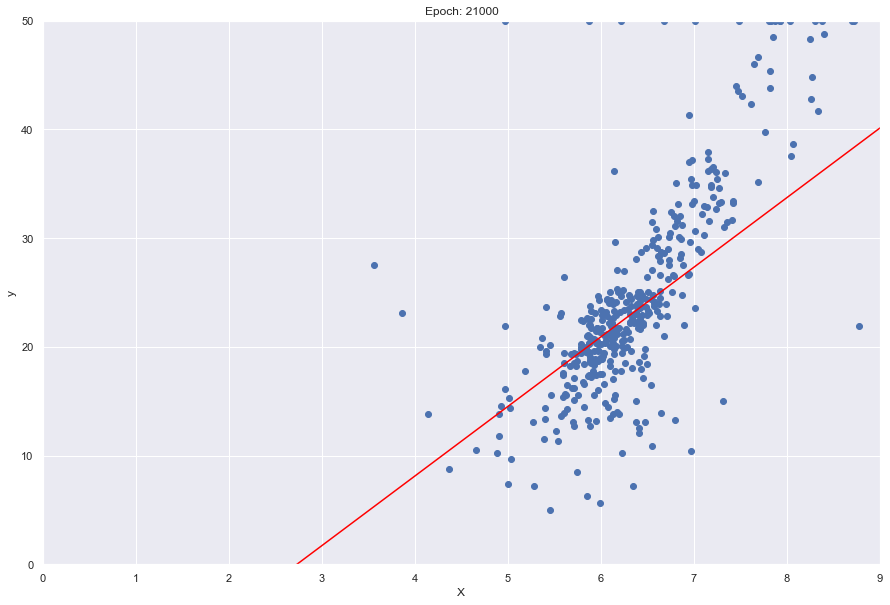

37.75780524385287 9.400144566894483 -35.33784473072722
43.934437853536565 6.401324688627597 -17.48026692723729
epoch:  21500 average loss:  41.64200727920783
Momentum leader: gradient_w2 = 2.9771473080387145, gradient_b2 = 0.8961925306685278, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 5.806395869823355e-06, mb1 = -3.726374477906934e-05
Momentum leader: guidance_w2 = 0.9999479115150502, guidance_b2 = 0.9999397859209023
Adam follower: mw2 = -1.9169686269077104, mb2 = -0.5186311929098623, sw2 = 0.036750935760203635, sb2 = 0.0026899893368945113


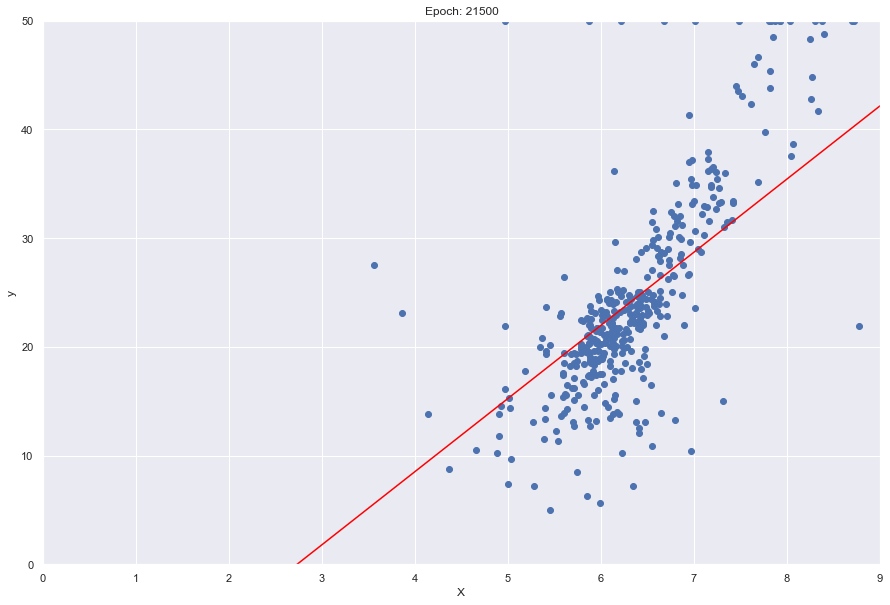

37.75772438774106 9.403241877169439 -35.35772235915191
41.64200727920783 6.727158997998185 -18.38244358642563
epoch:  22000 average loss:  41.64053691995837
Momentum leader: gradient_w2 = 42.04323353728494, gradient_b2 = 6.929972836274476, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 5.107106922151585e-06, mb1 = -3.277591352391881e-05
Momentum leader: guidance_w2 = 0.9996838102780813, guidance_b2 = 0.9995968992447739
Adam follower: mw2 = -21.469875027608627, mb2 = -3.536838570176746, sw2 = 4.6099393989005195, sb2 = 0.12510515644783307


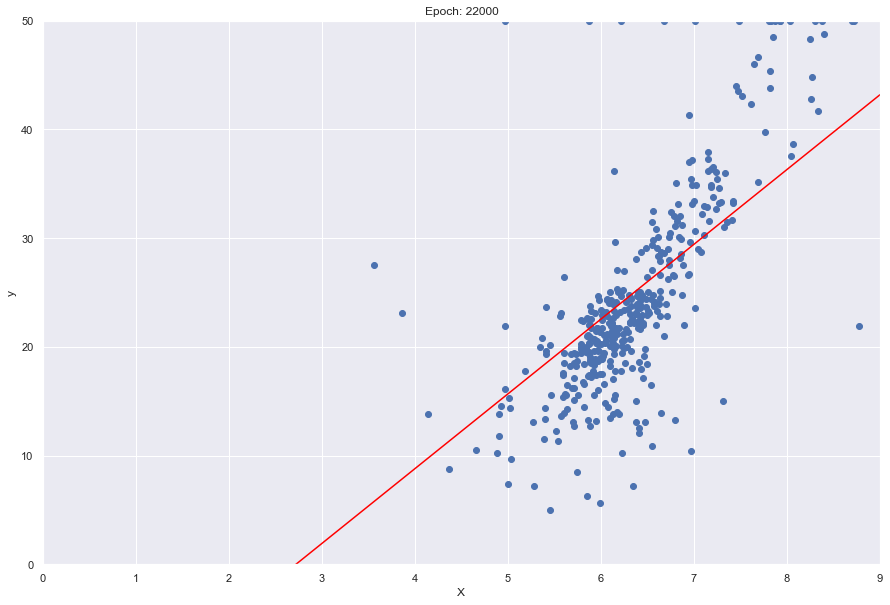

37.7576618345499 9.405966165196054 -35.37520604025183
41.64053691995837 6.877521191450616 -18.709831412994905
epoch:  22500 average loss:  41.30120913556115
Momentum leader: gradient_w2 = -22.950340850491365, gradient_b2 = -1.937314143446222, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 4.492036316429033e-06, mb1 = -2.8828570872197397e-05
Momentum leader: guidance_w2 = 0.9999842622955114, guidance_b2 = 0.9999753432361788
Adam follower: mw2 = 11.986717509965434, mb2 = 1.0449991185300789, sw2 = 1.4368951675973012, sb2 = 0.0109205040168177


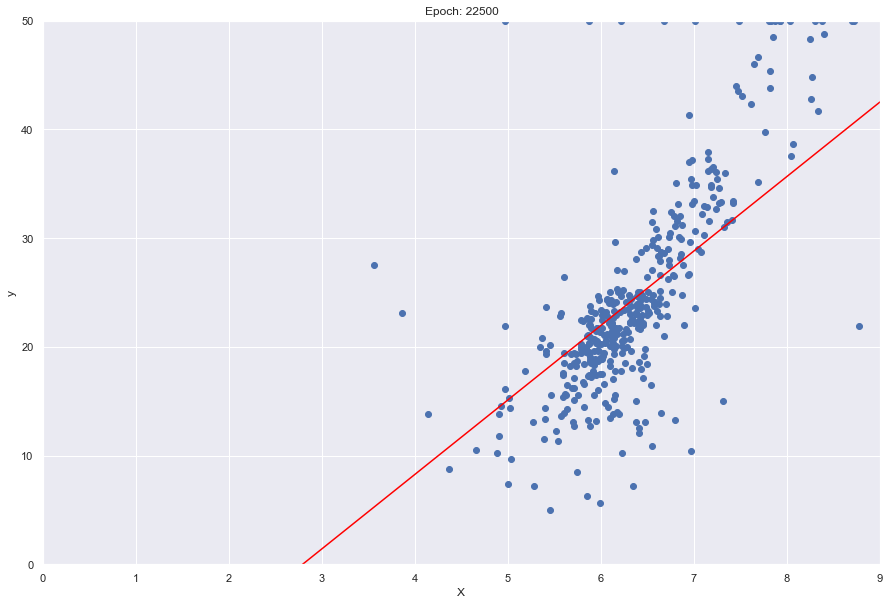

37.75761344115535 9.40836235563005 -35.39058408728409
41.30120913556115 6.849227922307648 -19.122467693122026
epoch:  23000 average loss:  41.02559689679305
Momentum leader: gradient_w2 = -11.476743139842371, gradient_b2 = 0.39548408126718754, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 3.951041279890835e-06, mb1 = -2.535662348283124e-05
Momentum leader: guidance_w2 = 0.9999732719821036, guidance_b2 = 0.9999485747157553
Adam follower: mw2 = 6.104073926269913, mb2 = -0.14251854691276883, sw2 = 0.37259103288661694, sb2 = 0.0002031508795937493


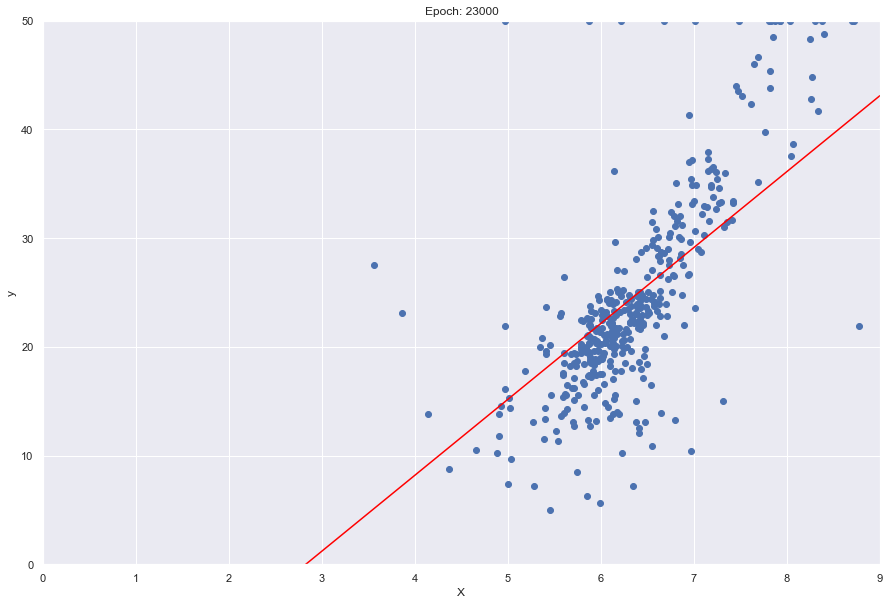

37.757576002287806 9.410469962659795 -35.40411009071399
41.02559689679305 6.982172271778031 -19.731866470105672
epoch:  23500 average loss:  40.931416546397905
Momentum leader: gradient_w2 = 110.26637308050293, gradient_b2 = 15.346954529022137, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 3.4752005757041045e-06, mb1 = -2.2302817482785882e-05
Momentum leader: guidance_w2 = 0.9926260330331792, guidance_b2 = 0.9942816937257829
Adam follower: mw2 = -55.600691590050154, mb2 = -7.745885736676619, sw2 = 30.928930636894815, sb2 = 0.6002383044057105


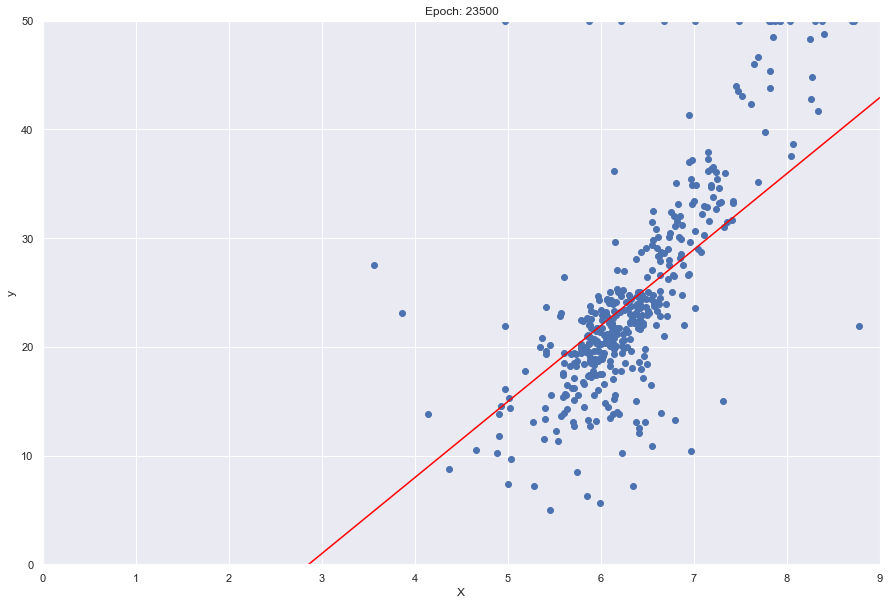

37.75754703823567 9.412323741611942 -35.41600710002889
40.931416546397905 6.989846450120694 -19.97318039108766
epoch:  24000 average loss:  40.849647108511654
Momentum leader: gradient_w2 = 52.165651506933735, gradient_b2 = 8.476775711568033, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 3.0566673916853745e-06, mb1 = -1.961679432615811e-05
Momentum leader: guidance_w2 = 0.999495473074228, guidance_b2 = 0.9993437161439732
Adam follower: mw2 = -26.529515573670682, mb2 = -4.310061007109598, sw2 = 7.038817390841149, sb2 = 0.185788845807518


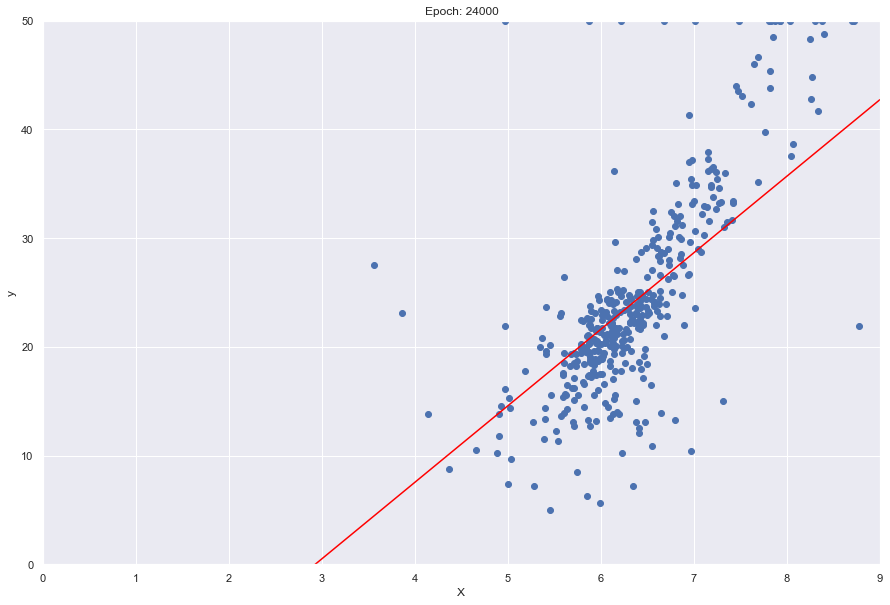

37.757524630605054 9.413954262081315 -35.42647130191759
40.849647108511654 7.038248755102458 -20.60408134603918
epoch:  24500 average loss:  40.55149427508519
Momentum leader: gradient_w2 = 21.096202716536045, gradient_b2 = 5.120836280841605, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 2.6885399380481284e-06, mb1 = -1.7254260361262973e-05
Momentum leader: guidance_w2 = 0.999879774447572, guidance_b2 = 0.9997720521740245
Adam follower: mw2 = -11.002940555843297, mb2 = -2.632638209633123, sw2 = 1.210755469552846, sb2 = 0.06931388161784993


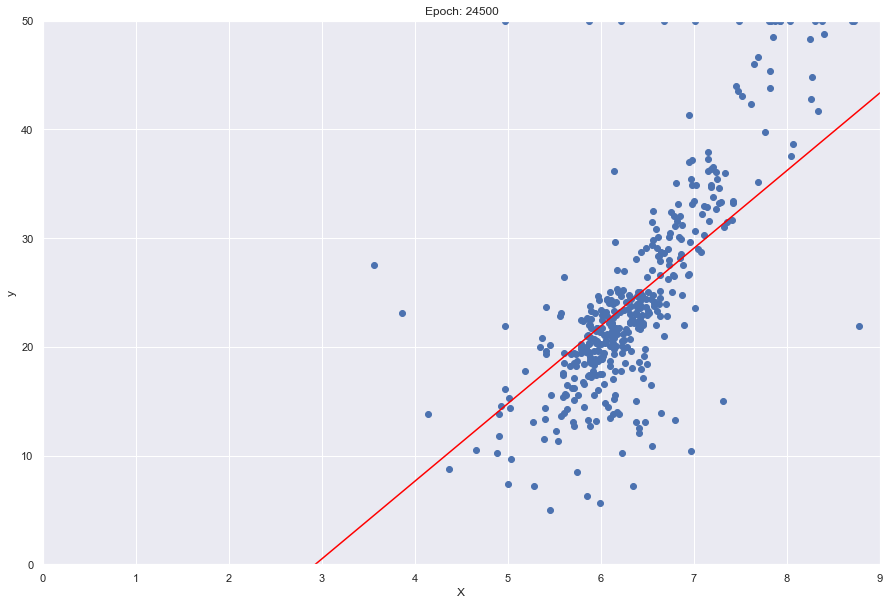

37.75750729525745 9.415388412036457 -35.43567525547175
40.55149427508519 7.1424319345774245 -20.92045053462002
epoch:  25000 average loss:  40.54853773623434
Momentum leader: gradient_w2 = 3.883397359809409, gradient_b2 = 1.9178433698354733, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 2.3647476402765592e-06, mb1 = -1.5176256408728022e-05
Momentum leader: guidance_w2 = 0.9999456861687737, guidance_b2 = 0.9999169174658379
Adam follower: mw2 = -2.404306322288169, mb2 = -1.0315866534332188, sw2 = 0.05781653064690499, sb2 = 0.010642729612436107


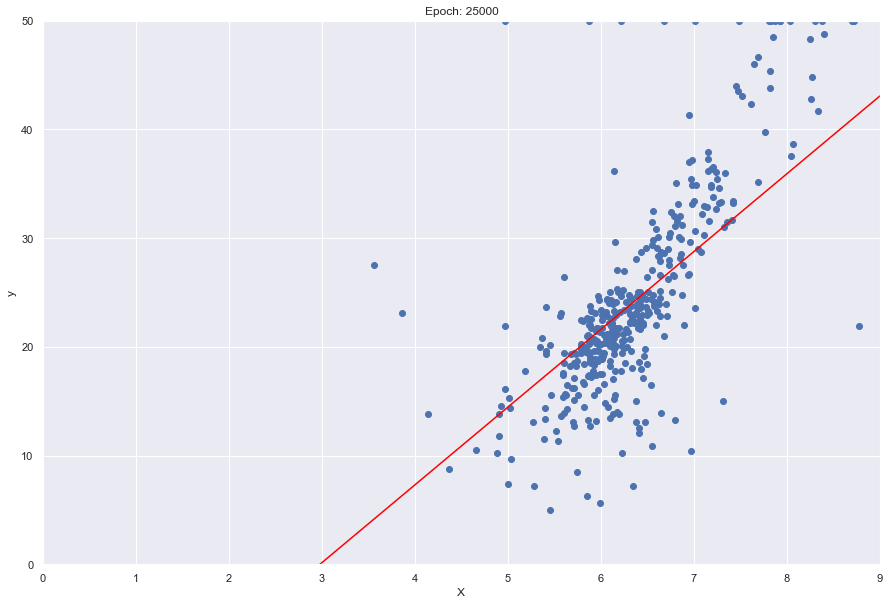

37.75749388401016 9.416649841213491 -35.44377073775775
40.54853773623434 7.154179977496901 -21.307913164173357
epoch:  25500 average loss:  40.441449554655165
Momentum leader: gradient_w2 = 18.965220246026547, gradient_b2 = 4.052739704003569, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 2.0799510253089397e-06, mb1 = -1.3348515309418088e-05
Momentum leader: guidance_w2 = 0.9998910381804457, guidance_b2 = 0.999837195005026
Adam follower: mw2 = -9.944133043216604, mb2 = -2.0992336522357515, sw2 = 0.9888915374506095, sb2 = 0.044069372772870694


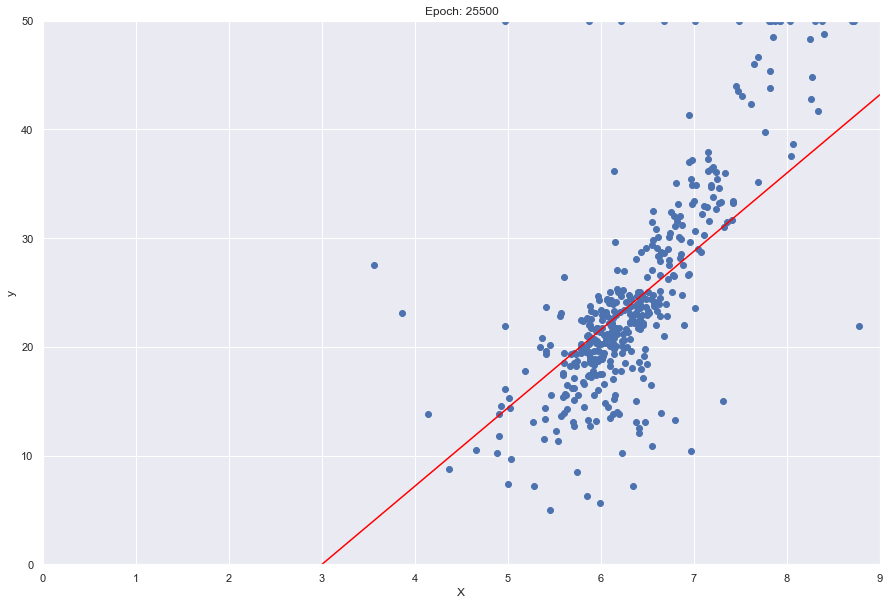

37.75748350858772 9.417759351110261 -35.450891246684414
40.441449554655165 7.200141636295865 -21.606929728786106
epoch:  26000 average loss:  40.190718965386864
Momentum leader: gradient_w2 = 11.361127884483285, gradient_b2 = -0.432690906626114, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 1.8294536781454884e-06, mb1 = -1.1740896843463329e-05
Momentum leader: guidance_w2 = 0.9999232946374705, guidance_b2 = 0.9999603866152726
Adam follower: mw2 = -6.002669288835827, mb2 = 0.16157823689659898, sw2 = 0.35935578272420093, sb2 = 0.00027417570674011433


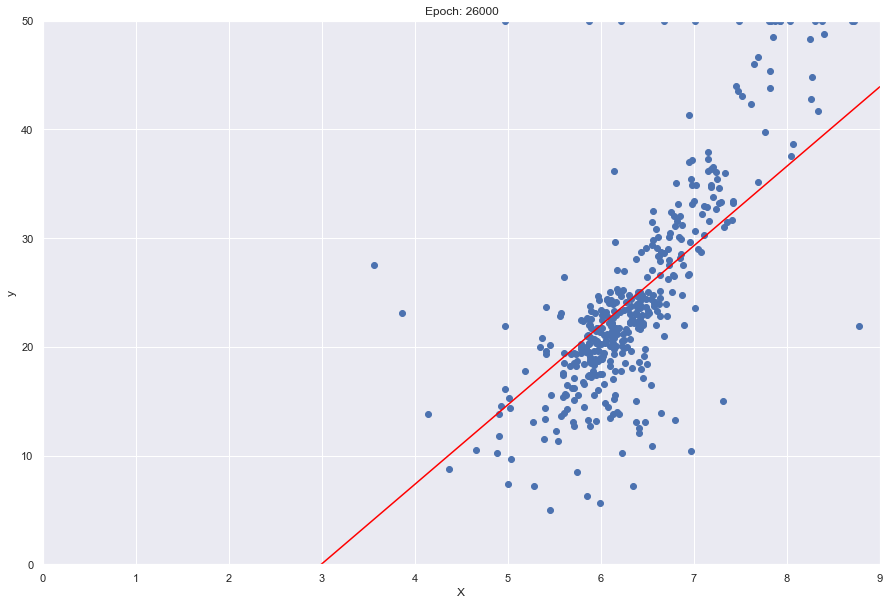

37.75747548178843 9.418735238011758 -35.457154202439725
40.190718965386864 7.3133105462148995 -21.888048914318645
epoch:  26500 average loss:  40.15616706301743
Momentum leader: gradient_w2 = 25.18125343362049, gradient_b2 = 5.438095859088401, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 1.609124791365355e-06, mb1 = -1.0326890706142237e-05
Momentum leader: guidance_w2 = 0.9998548239979383, guidance_b2 = 0.9997480861498963
Adam follower: mw2 = -13.044340081354619, mb2 = -2.791153682060518, sw2 = 1.701642781311253, sb2 = 0.07791216825750515


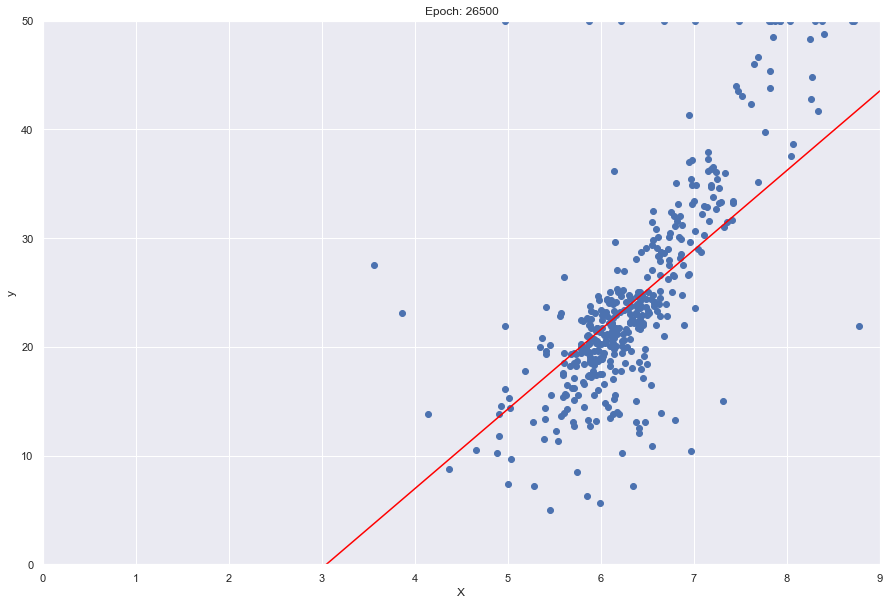

37.75746927196827 9.419593594703555 -35.46266288379896
40.15616706301743 7.316550337736629 -22.300327948208263
epoch:  27000 average loss:  39.93789569849873
Momentum leader: gradient_w2 = -1.1244937049787556, gradient_b2 = 1.0224584113602817, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 1.415331049843925e-06, mb1 = -9.083179341220354e-06
Momentum leader: guidance_w2 = 0.9999568966456766, guidance_b2 = 0.9999373418767975
Adam follower: mw2 = 0.886445432649594, mb2 = -0.45935356830578034, sw2 = 0.00785483083078768, sb2 = 0.002110391231843348


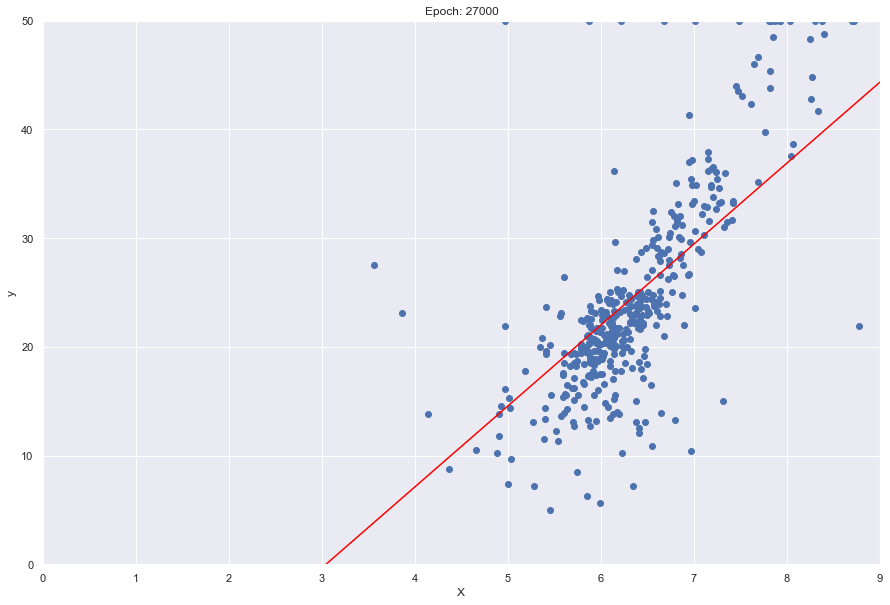

37.757464467828484 9.420348575848628 -35.46750813123534
39.93789569849873 7.445450788039495 -22.657872839885474
epoch:  27500 average loss:  39.77469749529392
Momentum leader: gradient_w2 = 41.880966933147704, gradient_b2 = 7.370691653424587, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 1.2448767125747427e-06, mb1 = -7.98925342513032e-06
Momentum leader: guidance_w2 = 0.9996861699038755, guidance_b2 = 0.9995368459662481
Adam follower: mw2 = -21.374421170447473, mb2 = -3.7561857243523233, sw2 = 4.568860303150153, sb2 = 0.1410957637460591


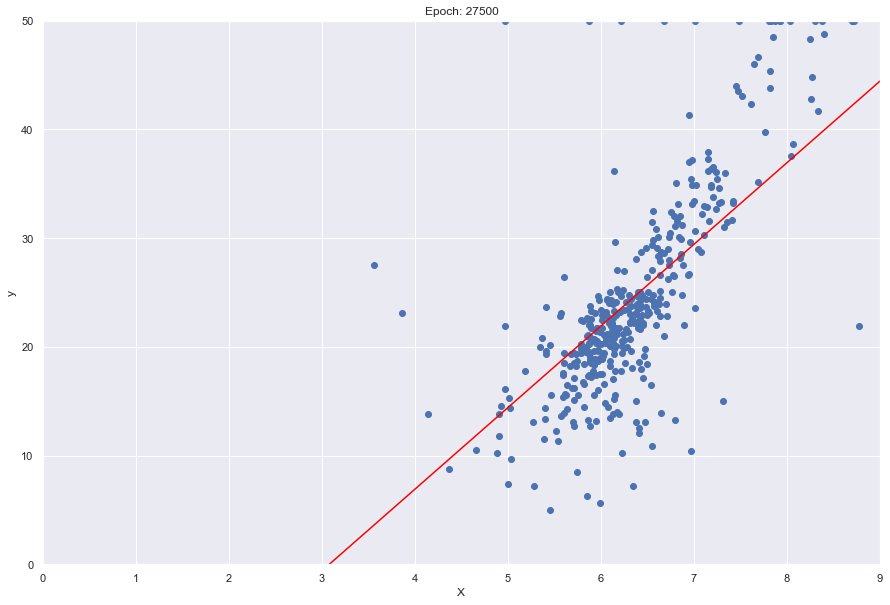

37.75746075117341 9.421012631403693 -35.471769844917574
39.77469749529392 7.506216016074899 -23.112829171065766
epoch:  28000 average loss:  39.65123121205279
Momentum leader: gradient_w2 = -37.963227203136455, gradient_b2 = -5.446179985663067, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 1.0949509159136557e-06, mb1 = -7.02707365928577e-06
Momentum leader: guidance_w2 = 0.9999921302754203, guidance_b2 = 0.9999918388377226
Adam follower: mw2 = 19.428273803070315, mb2 = 2.794576134760063, sw2 = 3.774871040421451, sb2 = 0.07810688588178125


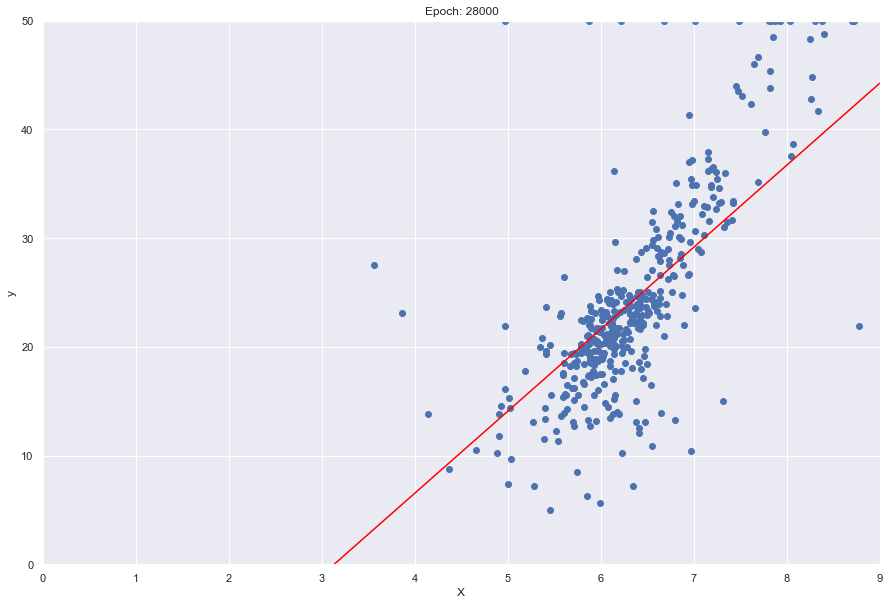

37.757457875835634 9.421596711924227 -35.47551830229724
39.65123121205279 7.542489073881795 -23.616589981477304
epoch:  28500 average loss:  39.519409158965246
Momentum leader: gradient_w2 = -17.871916932371178, gradient_b2 = -2.261996394329176, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 9.630813203463193e-07, mb1 = -6.180773294508114e-06
Momentum leader: guidance_w2 = 0.9999801045019585, guidance_b2 = 0.9999777410998916
Adam follower: mw2 = 9.421240466737833, mb2 = 1.2054582577012944, sw2 = 0.887663777520554, sb2 = 0.014532463634601402


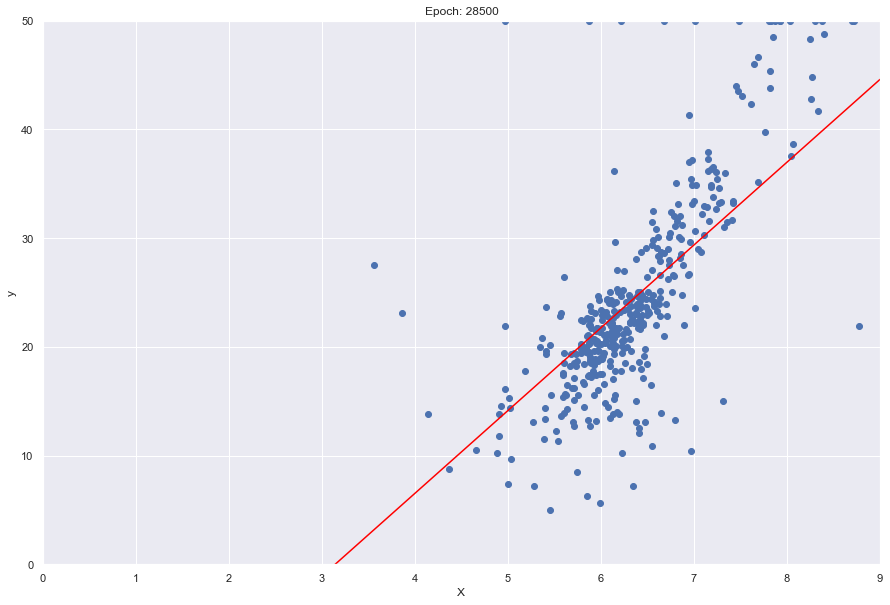

37.75745565137108 9.422110449143766 -35.478815317013684
39.519409158965246 7.6130366631981135 -23.92095944136503
epoch:  29000 average loss:  39.81532679872893
Momentum leader: gradient_w2 = 24.597161666901595, gradient_b2 = 1.8557210701695424, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 8.470933417231095e-07, mb1 = -5.436396481626659e-06
Momentum leader: guidance_w2 = 0.9998586861188979, guidance_b2 = 0.999918528000877
Adam follower: mw2 = -12.769662203593079, mb2 = -1.0011548115735414, sw2 = 1.6306056952395125, sb2 = 0.010022854982141465


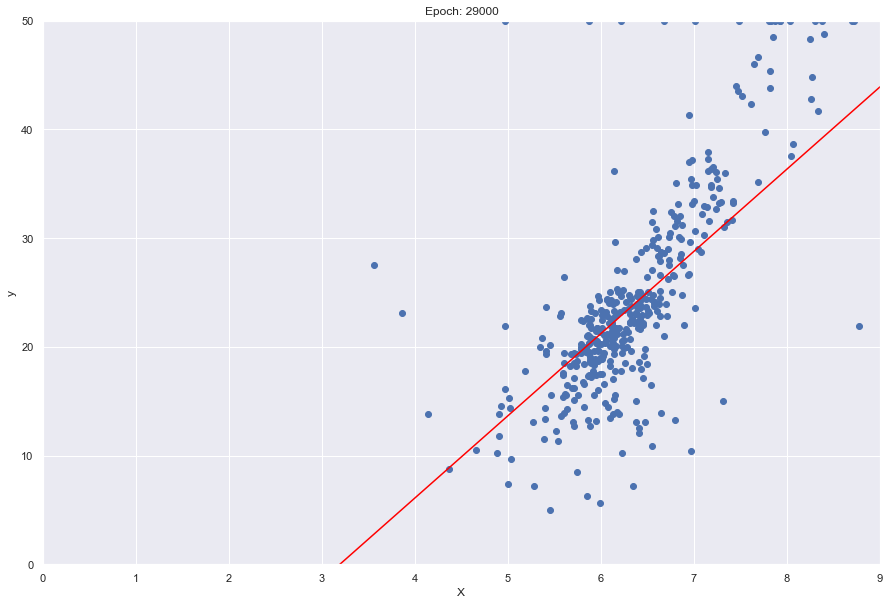

37.75745393044547 9.422562314805177 -35.48171525822656
39.81532679872893 7.5612152682240295 -24.140584811711964
epoch:  29500 average loss:  39.35075369578895
Momentum leader: gradient_w2 = 53.90533558432725, gradient_b2 = 8.936805795845602, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 7.450742880037781e-07, mb1 = -4.78166813400147e-06
Momentum leader: guidance_w2 = 0.9994532838016348, guidance_b2 = 0.999241341577297
Adam follower: mw2 = -27.405067409144262, mb2 = -4.540488118900442, sw2 = 7.510772775045982, sb2 = 0.2061665290060413


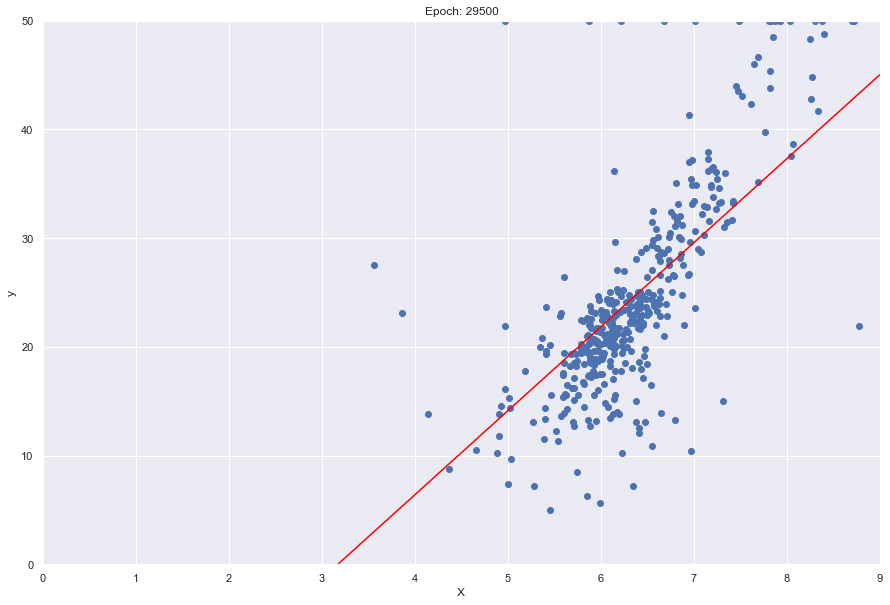

37.75745259907558 9.422959760363344 -35.48426594718665
39.35075369578895 7.728174739126946 -24.5099363586534
epoch:  30000 average loss:  39.211403469462724
Momentum leader: gradient_w2 = 26.786051485436275, gradient_b2 = 5.161167372627134, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 6.553418233340558e-07, mb1 = -4.205791505592486e-06
Momentum leader: guidance_w2 = 0.9998436606872105, guidance_b2 = 0.9997691367975005
Adam follower: mw2 = -13.860325636780798, mb2 = -2.653849821357866, sw2 = 1.921250220240631, sb2 = 0.07043626602961298


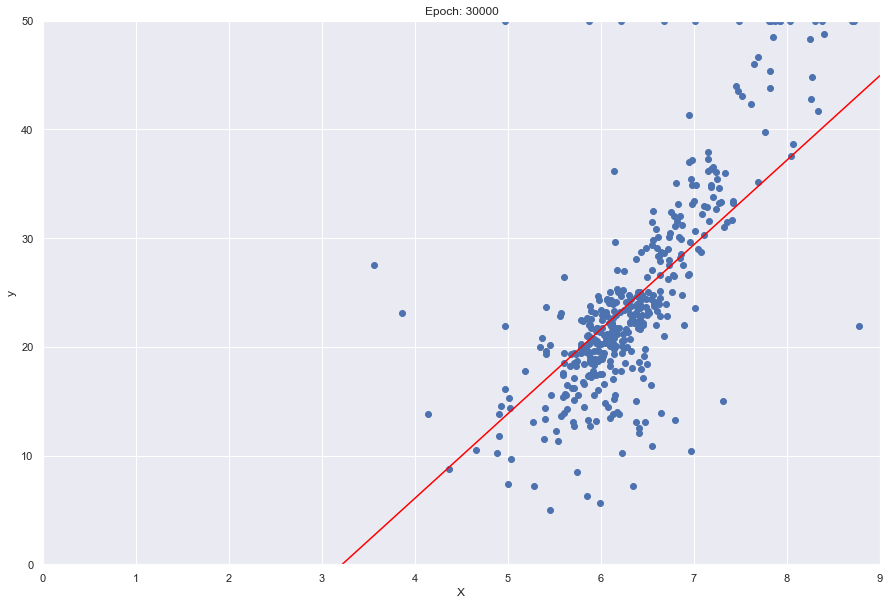

37.75745156908004 9.423309339862708 -35.48650944582785
39.211403469462724 7.774974247115066 -25.02181794586313
epoch:  30500 average loss:  39.0770241630571
Momentum leader: gradient_w2 = -28.38234180029264, gradient_b2 = -3.6493136923778686, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 5.764162206013583e-07, mb1 = -3.6992701486253225e-06
Momentum leader: guidance_w2 = 0.9999877527280293, guidance_b2 = 0.9999856235717831
Adam follower: mw2 = 14.621778535550769, mb2 = 1.8949855164449696, sw2 = 2.137953282615951, sb2 = 0.03590945469022719


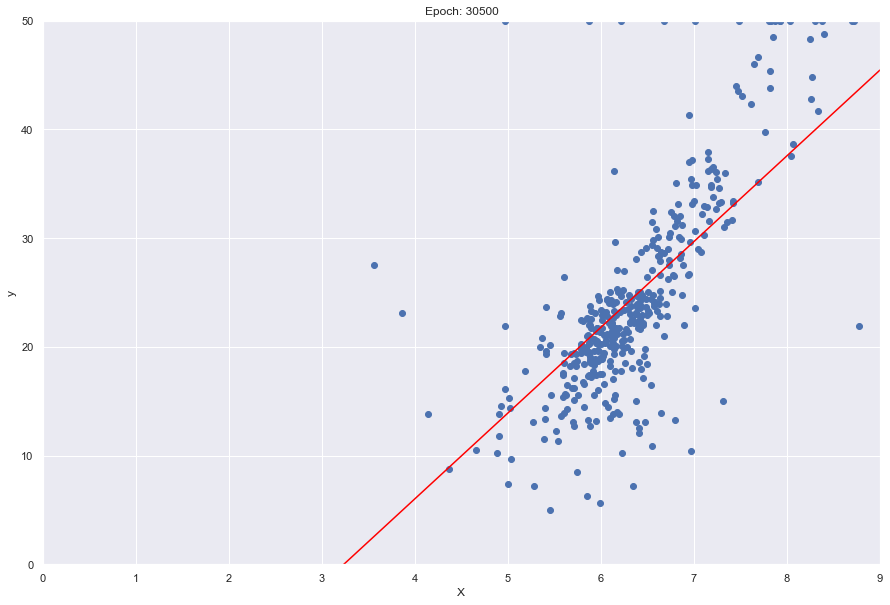

37.75745077223852 9.423616818016315 -35.4884827503868
39.0770241630571 7.885591424216556 -25.511298594286167
epoch:  31000 average loss:  38.987754493022884
Momentum leader: gradient_w2 = 14.532690183693573, gradient_b2 = 4.042569784145409, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 5.069959632553211e-07, mb1 = -3.2537513128272637e-06
Momentum leader: guidance_w2 = 0.9999112006168893, guidance_b2 = 0.999837715895286
Adam follower: mw2 = -7.764684338336283, mb2 = -2.0974131718564393, sw2 = 0.6013285622960078, sb2 = 0.04392300624502901


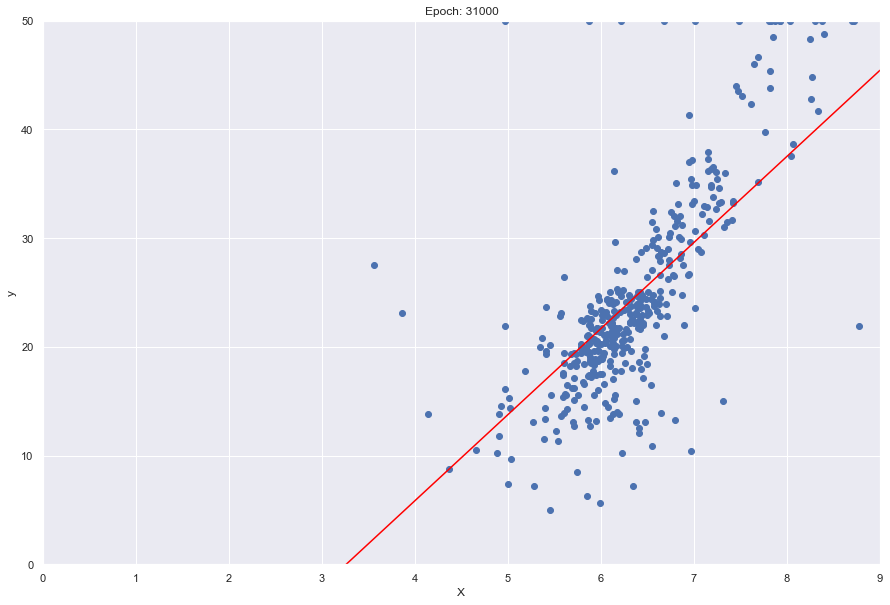

37.75745015577333 9.423887265268286 -35.49021840148596
38.987754493022884 7.917084194553268 -25.81632277321553
epoch:  31500 average loss:  38.92971045220085
Momentum leader: gradient_w2 = -12.26949589176002, gradient_b2 = -2.208809016064209, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 4.459362834520985e-07, mb1 = -2.8618882049540175e-06
Momentum leader: guidance_w2 = 0.9999742324302054, guidance_b2 = 0.9999773649046076
Adam follower: mw2 = 6.580742134063207, mb2 = 1.1759615128415115, sw2 = 0.43304826951400893, sb2 = 0.013828557693679295


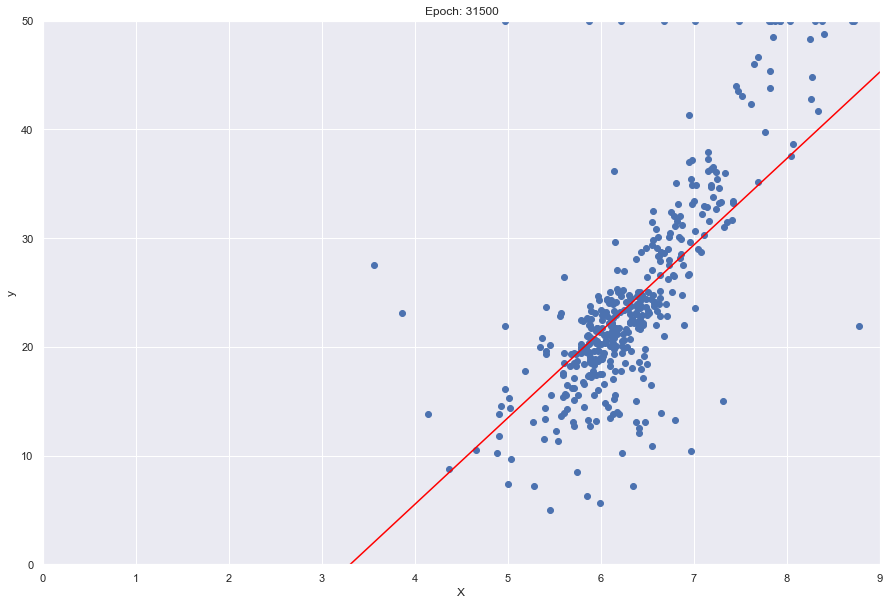

37.75744967885368 9.424125141407574 -35.49174502074207
38.92971045220085 7.951968712360994 -26.28216284659432
epoch:  32000 average loss:  38.794262374294576
Momentum leader: gradient_w2 = -6.636992000552998, gradient_b2 = 0.5432626715161722, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 3.922302805211794e-07, mb1 = -2.517218837668956e-06
Momentum leader: guidance_w2 = 0.9999665808642166, guidance_b2 = 0.9999461234195979
Adam follower: mw2 = 3.637795284827457, mb2 = -0.22302876742466335, sw2 = 0.13354420561684469, sb2 = 0.0004808952918767436


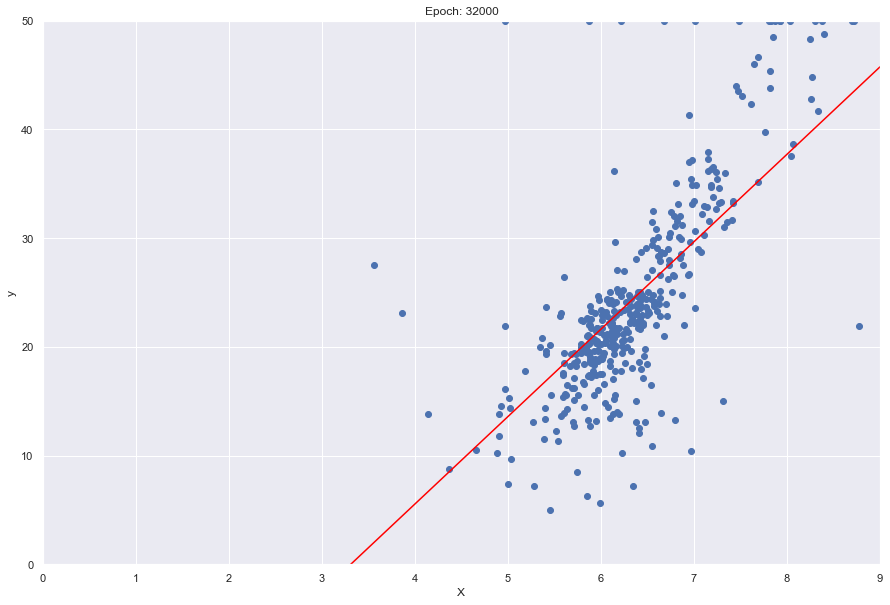

37.75744930989157 9.42433436911178 -35.49308778274884
38.794262374294576 8.040025399129172 -26.61068144515603
epoch:  32500 average loss:  38.71819278683537
Momentum leader: gradient_w2 = -50.85855601280993, gradient_b2 = -8.113697851615488, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 3.449923197093332e-07, mb1 = -2.2140594680866502e-06
Momentum leader: guidance_w2 = 0.9999956605871672, guidance_b2 = 0.9999964786806894
Adam follower: mw2 = 25.872768041118075, mb2 = 4.127935310036691, sw2 = 6.694823851791824, sb2 = 0.17042621456813017


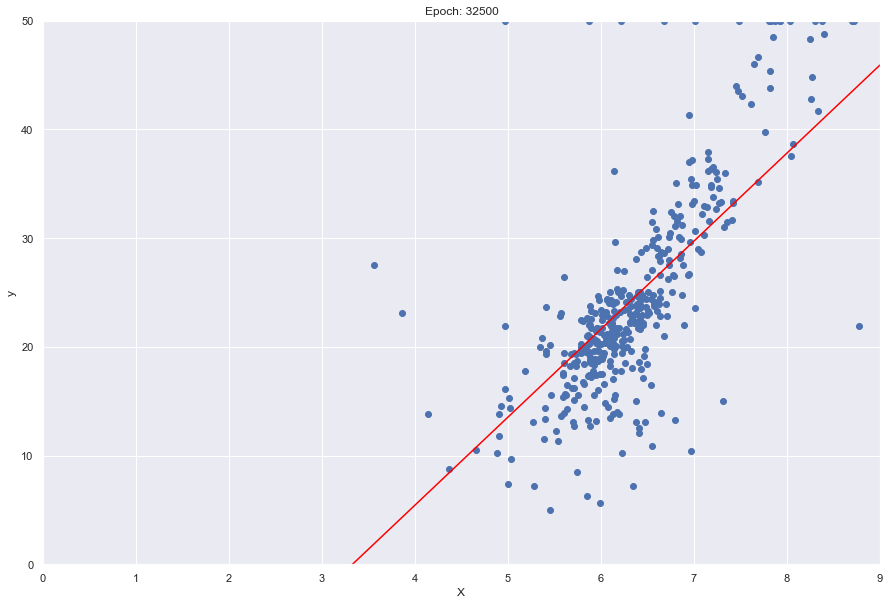

37.75744902444921 9.424518398633788 -35.49426883021679
38.71819278683537 8.096223973625218 -26.94511855401648
epoch:  33000 average loss:  38.99178400440599
Momentum leader: gradient_w2 = 61.49331228978882, gradient_b2 = 9.78750773356879, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 3.034434271870157e-07, mb1 = -1.9474108706737868e-06
Momentum leader: guidance_w2 = 0.9992239539885225, guidance_b2 = 0.9990081092991248
Adam follower: mw2 = -31.20680535193256, mb2 = -4.966290684320187, sw2 = 9.739981671670057, sb2 = 0.24668770399835116


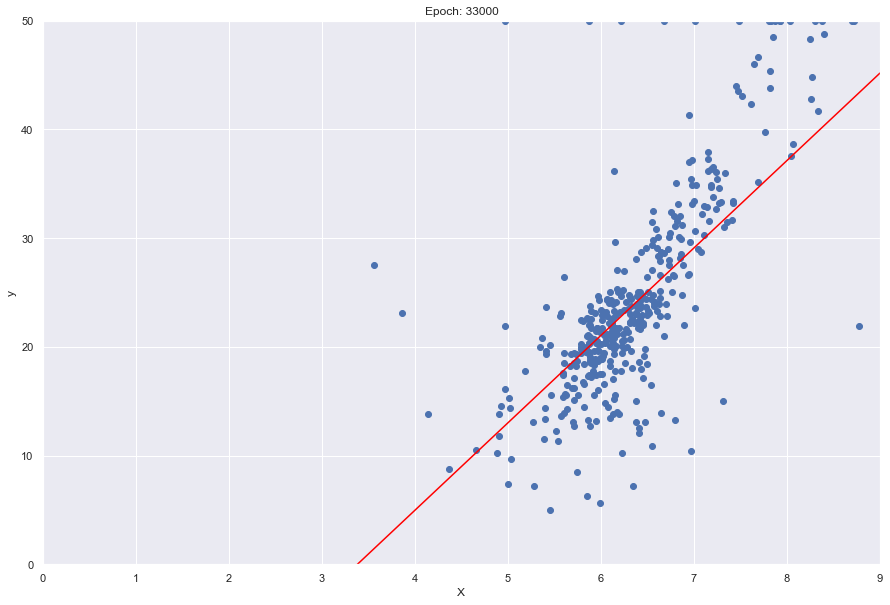

37.75744880362075 9.42468026469784 -35.4953076391155
38.99178400440599 8.041062474935151 -27.18946360145683
epoch:  33500 average loss:  38.68465724888673
Momentum leader: gradient_w2 = 2.854146965327437, gradient_b2 = 1.0794364335535307, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 2.668984451815573e-07, mb1 = -1.71287589768162e-06
Momentum leader: guidance_w2 = 0.9999482064372495, guidance_b2 = 0.999936206745918
Adam follower: mw2 = -1.8907787877092026, mb2 = -0.6129578481112586, sw2 = 0.035722357252387565, sb2 = 0.0037545257773684082


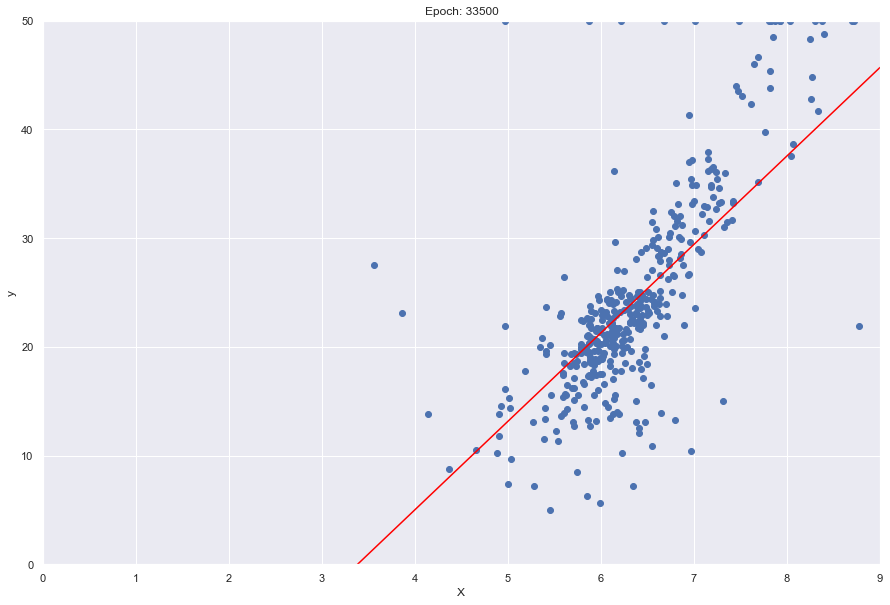

37.75744863277994 9.424822636543444 -35.49622133984092
38.68465724888673 8.134747738993838 -27.518433916161683
epoch:  34000 average loss:  38.546581338111785
Momentum leader: gradient_w2 = -60.23848505820206, gradient_b2 = -6.3064402351033415, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 2.3475473040223783e-07, mb1 = -1.5065869689813671e-06
Momentum leader: guidance_w2 = 0.999997185637987, guidance_b2 = 0.9999937766183481
Adam follower: mw2 = 30.62725457883428, mb2 = 3.2260843907856835, sw2 = 9.388032666313872, sb2 = 0.10432194604080006


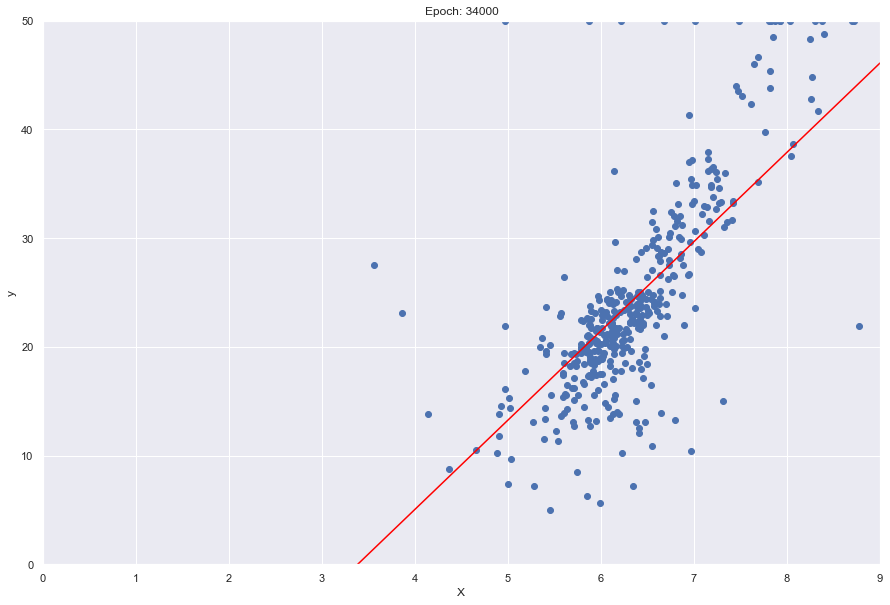

37.75744850061134 9.424947861942202 -35.497024999702155
38.546581338111785 8.209553689823228 -27.78420738049275
epoch:  34500 average loss:  38.53222528734652
Momentum leader: gradient_w2 = 19.239945772677572, gradient_b2 = 4.668453641981899, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 2.0648221998075574e-07, mb1 = -1.3251422932029322e-06
Momentum leader: guidance_w2 = 0.9998896475172674, guidance_b2 = 0.9998023360655676
Adam follower: mw2 = -10.106308344193849, mb2 = -2.4106173028616134, sw2 = 1.0182252971132835, sb2 = 0.05796780065859107


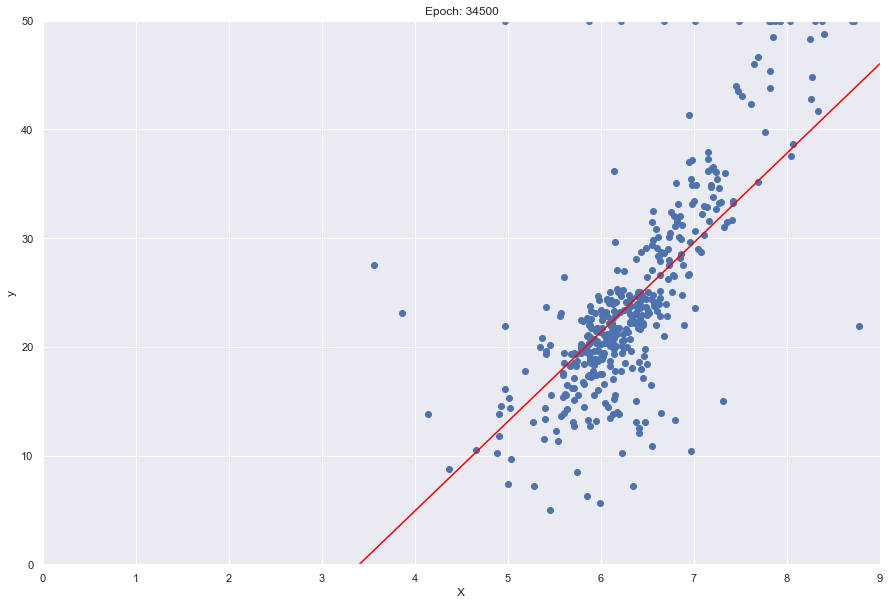

37.75744839836095 9.425058005913657 -35.497731871388716
38.53222528734652 8.226867346371469 -27.99663779825802
epoch:  35000 average loss:  38.50928469382687
Momentum leader: gradient_w2 = 31.96791062101528, gradient_b2 = 3.9852655565251074, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 1.8161468839716288e-07, mb1 = -1.1655497713652204e-06
Momentum leader: guidance_w2 = 0.9998014109395525, guidance_b2 = 0.9998406199460641
Adam follower: mw2 = -16.468597084836347, mb2 = -2.066608634463062, sw2 = 2.7123924813552556, sb2 = 0.042712822370332186


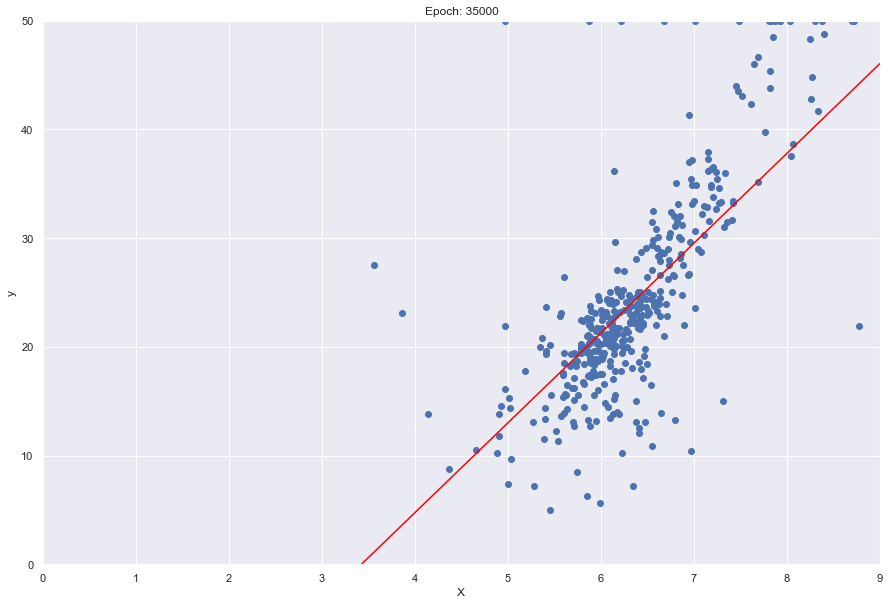

37.7574483192564 9.425154884778202 -35.49835361151182
38.50928469382687 8.260636664979474 -28.287112919879625
epoch:  35500 average loss:  38.40858414023797
Momentum leader: gradient_w2 = -25.414726825333698, gradient_b2 = -3.1989166821065376, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 1.5974205886330239e-07, mb1 = -1.0251776557123963e-06
Momentum leader: guidance_w2 = 0.9999859545777356, guidance_b2 = 0.9999834313437298
Adam follower: mw2 = 13.200207215165273, mb2 = 1.6741228089513431, sw2 = 1.7428786222404118, sb2 = 0.028037866057405922


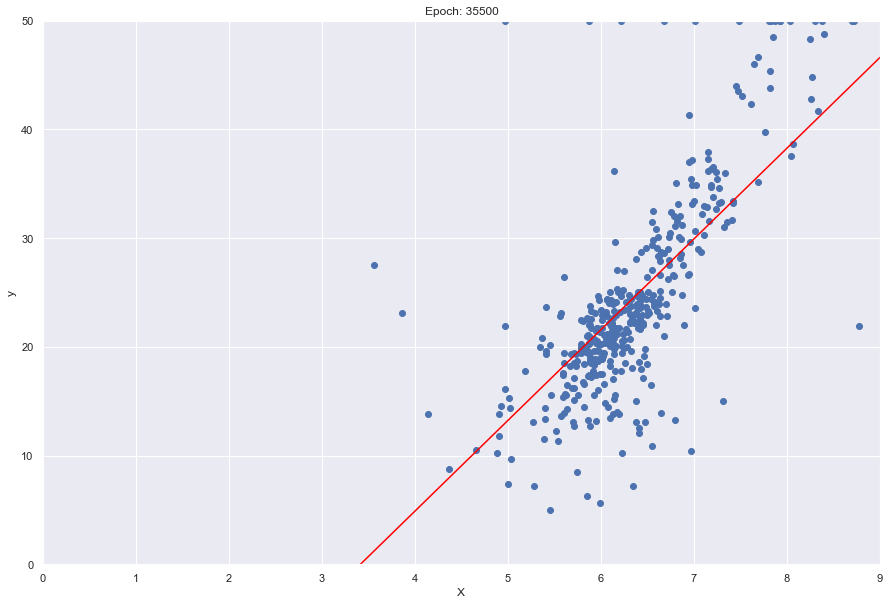

37.75744825805828 9.425240096109098 -35.498900472827835
38.40858414023797 8.345126017807287 -28.487777255904604
epoch:  36000 average loss:  38.44231357813527
Momentum leader: gradient_w2 = 16.82306067777747, gradient_b2 = 3.4587510698120556, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 1.4050364314346663e-07, mb1 = -9.017111509147149e-07
Momentum leader: guidance_w2 = 0.9999012975730526, guidance_b2 = 0.9998649852873386
Adam follower: mw2 = -8.908222791797233, mb2 = -1.8046043547890185, sw2 = 0.7935828544991922, sb2 = 0.03256701287927095


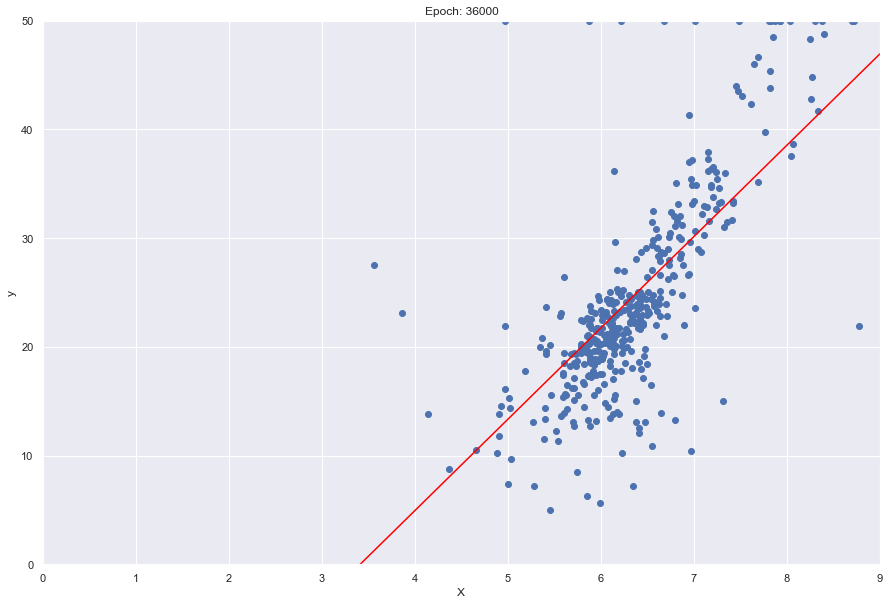

37.75744821071319 9.425315045077024 -35.49938147330989
38.44231357813527 8.40095964551103 -28.656483625497753
epoch:  36500 average loss:  38.304546389670286
Momentum leader: gradient_w2 = -34.19766858916244, gradient_b2 = -2.63935634804046, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 1.2358219181271809e-07, mb1 = -7.931142423226993e-07
Momentum leader: guidance_w2 = 0.999990636195621, guidance_b2 = 0.9999802365642769
Adam follower: mw2 = 16.619670090203684, mb2 = 1.309046011530943, sw2 = 3.0847525424965756, sb2 = 0.019325245828646254


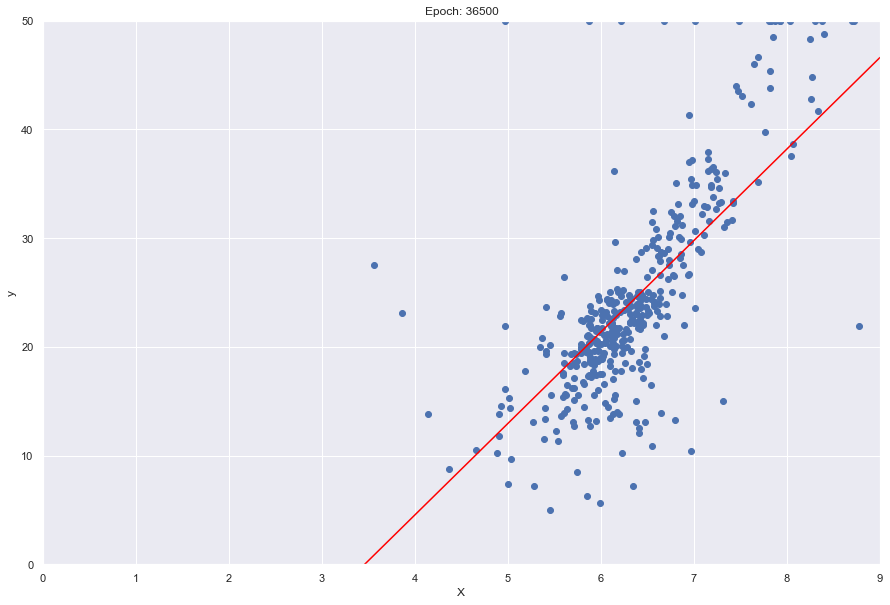

37.75744817408536 9.425380967622015 -35.49980454485835
38.304546389670286 8.41328740960463 -29.104952601111332
epoch:  37000 average loss:  38.33022427593209
Momentum leader: gradient_w2 = 48.65588718083519, gradient_b2 = 7.459367263546086, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 1.0869866309890479e-07, mb1 = -6.975961212296121e-07
Momentum leader: guidance_w2 = 0.9995709382758067, guidance_b2 = 0.9995237219123454
Adam follower: mw2 = -24.776347750861223, mb2 = -3.8013383920905417, sw2 = 6.13940876694446, sb2 = 0.14451610841362722


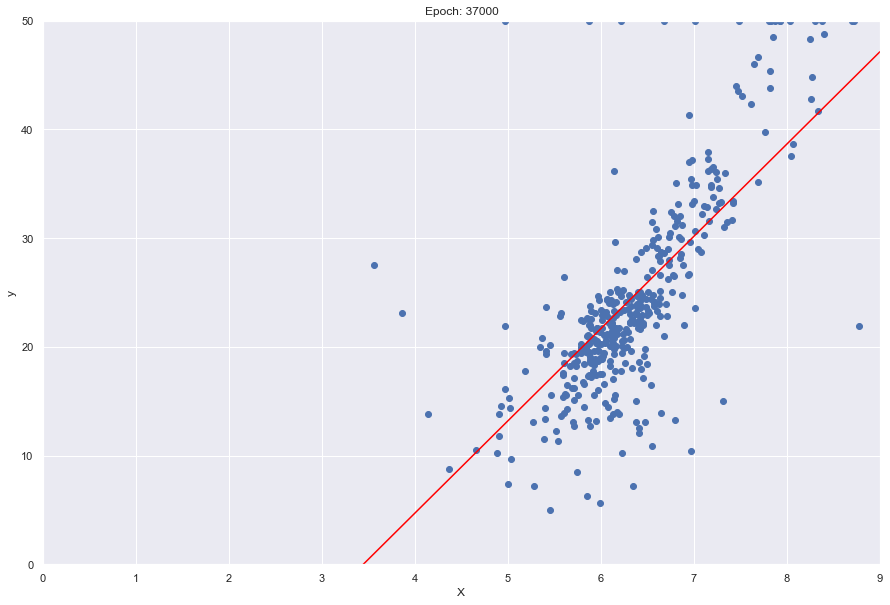

37.75744814574873 9.425438950834561 -35.500176664101026
38.33022427593209 8.486590023312012 -29.232275395392005
epoch:  37500 average loss:  38.283787625622075
Momentum leader: gradient_w2 = -67.29177150675213, gradient_b2 = -12.297042885141348, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 9.560762094423958e-08, mb1 = -6.135816536622501e-07
Momentum leader: guidance_w2 = 0.9999979677645362, guidance_b2 = 0.9999990576338404
Adam follower: mw2 = 34.094144663213804, mb2 = 6.217017472147931, sw2 = 11.638185452270262, sb2 = 0.3870543301056719


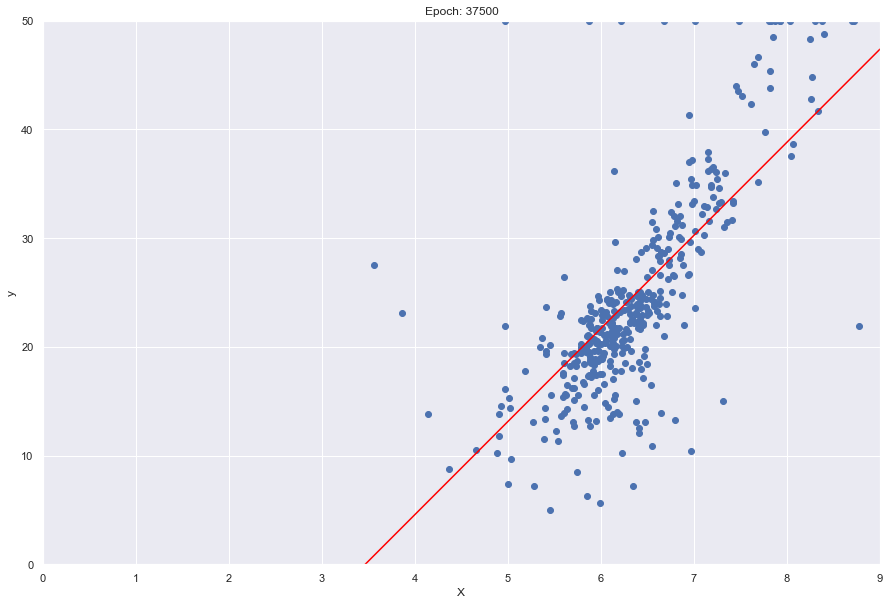

37.757448123826535 9.425489950882243 -35.50050396744087
38.283787625622075 8.560693003904566 -29.664984731061697
epoch:  38000 average loss:  38.20185888983939
Momentum leader: gradient_w2 = 66.32541309526849, gradient_b2 = 8.475341290981087, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 8.40931878061138e-08, mb1 = -5.396854058431933e-07
Momentum leader: guidance_w2 = 0.999030020497384, guidance_b2 = 0.9993440127136548
Adam follower: mw2 = -33.61720770034817, mb2 = -4.309791186673134, sw2 = 11.301902748735799, sb2 = 0.1857562528331565


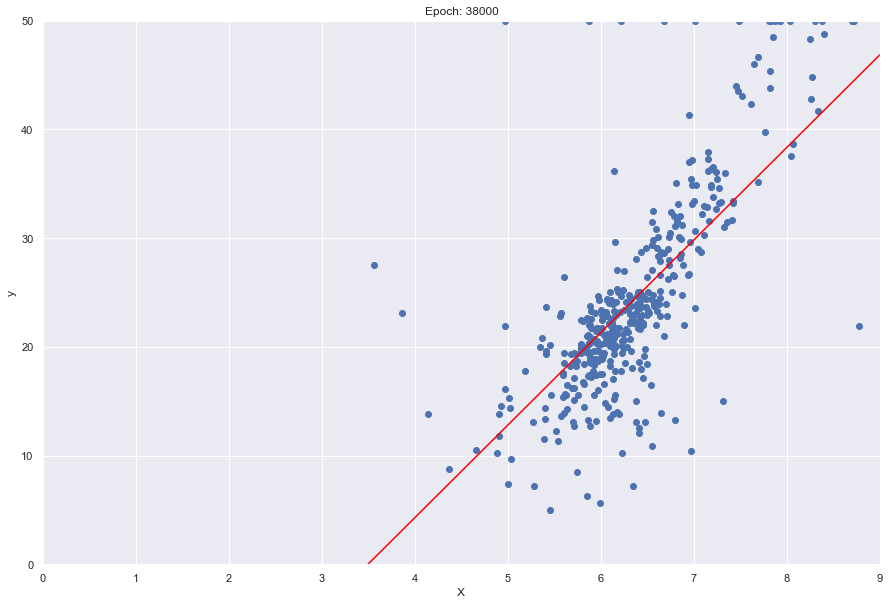

37.75744810686671 9.4255348087773 -35.50079185224758
38.20185888983939 8.513764078079218 -29.75151990881432
epoch:  38500 average loss:  38.197810848173475
Momentum leader: gradient_w2 = 24.46412438666607, gradient_b2 = 4.368437950538653, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 7.396548791819223e-08, mb1 = -4.746887972273907e-07
Momentum leader: guidance_w2 = 0.9998595513200442, guidance_b2 = 0.9998201664780553
Adam follower: mw2 = -12.671138900203925, mb2 = -2.2555278603583955, sw2 = 1.605694080847006, sb2 = 0.05087592573672105


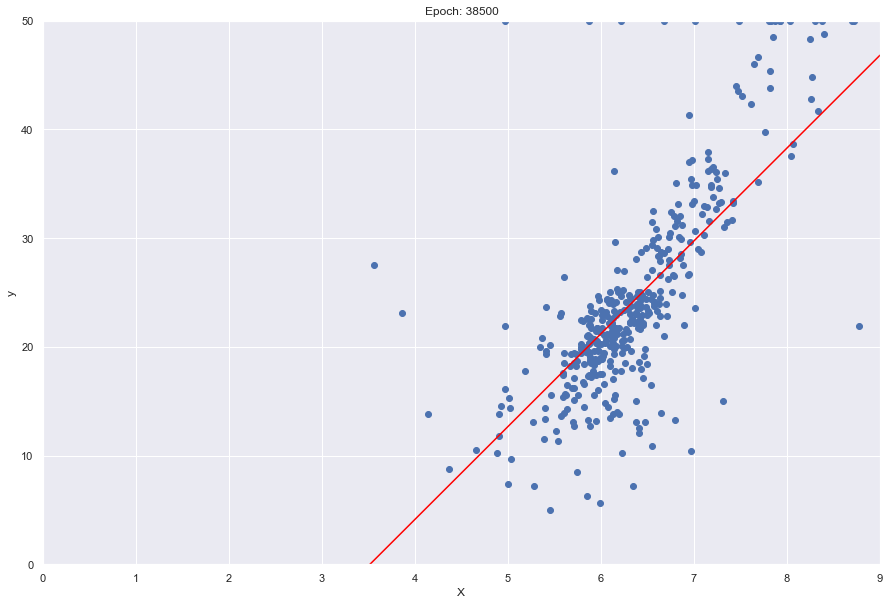

37.75744809374599 9.425574264245288 -35.50104506586275
38.197810848173475 8.538205450219627 -30.021066267425265
epoch:  39000 average loss:  38.1769231864862
Momentum leader: gradient_w2 = -16.03164307600892, gradient_b2 = -2.228550741983101, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 6.505750987744883e-08, mb1 = -4.175200066392165e-07
Momentum leader: guidance_w2 = 0.9999783404686536, guidance_b2 = 0.9999775052745099
Adam follower: mw2 = 8.486950056205398, mb2 = 1.1878993895282914, sw2 = 0.7203515907257464, sb2 = 0.014111433401945634


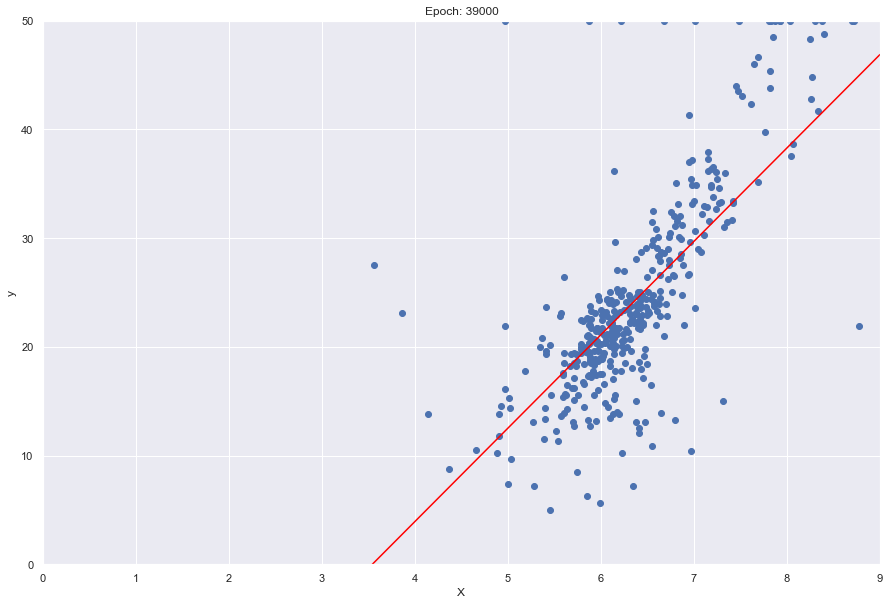

37.75744808359533 9.425608967923464 -35.50126778388533
38.1769231864862 8.589765562101134 -30.4217822246149
epoch:  39500 average loss:  38.10724270933534
Momentum leader: gradient_w2 = 45.46285194962136, gradient_b2 = 7.944551531433003, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 5.722235745221926e-08, mb1 = -3.6723629665330593e-07
Momentum leader: guidance_w2 = 0.9996297414829209, guidance_b2 = 0.9994450453643259
Adam follower: mw2 = -23.19414082697527, mb2 = -4.045094617674165, sw2 = 5.379940436056016, sb2 = 0.16363793626084597


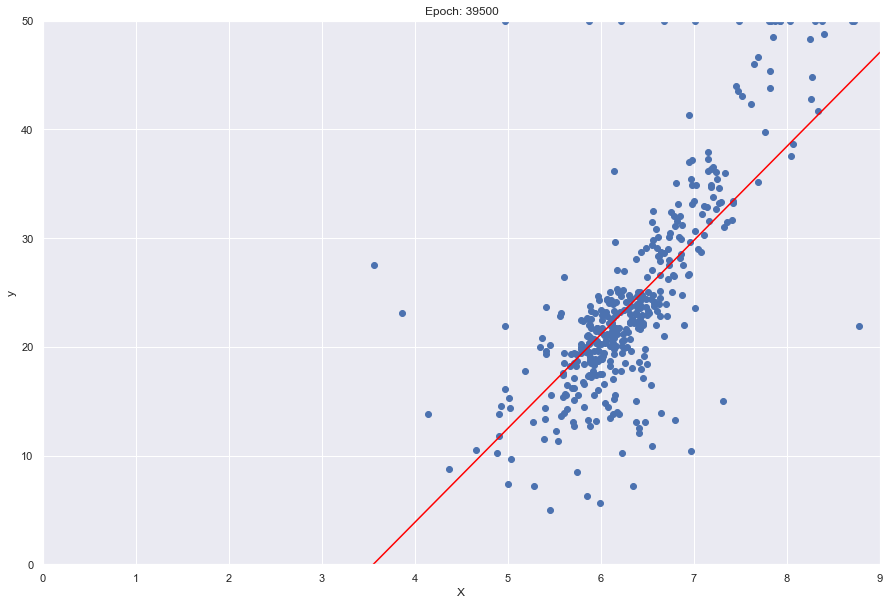

37.75744807574238 9.425639492090086 -35.501463679029264
38.10724270933534 8.645026390763523 -30.712830656510597
epoch:  40000 average loss:  38.18689843976958
Momentum leader: gradient_w2 = 18.184871117083457, gradient_b2 = 3.6199899521563177, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 5.033082596390644e-08, mb1 = -3.23008467665315e-07
Momentum leader: guidance_w2 = 0.9998948934635115, guidance_b2 = 0.9998579482974742
Adam follower: mw2 = -9.58414832560905, mb2 = -1.8873194300903662, sw2 = 0.9146212572744271, sb2 = 0.035479833612830414


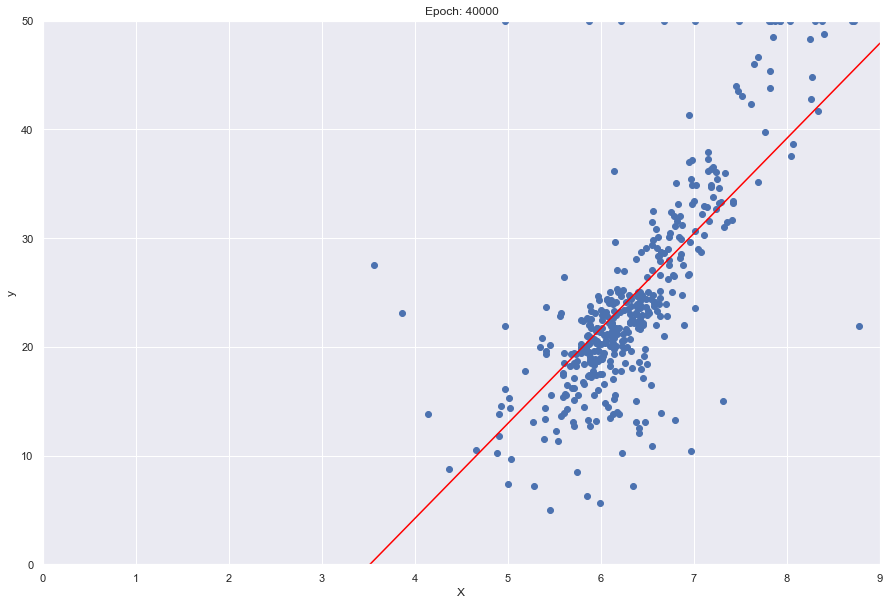

37.75744806966711 9.425666340101511 -35.50163598168789
38.18689843976958 8.741016002151046 -30.740548936256378
epoch:  40500 average loss:  38.227651836999534
Momentum leader: gradient_w2 = -23.776349675516535, gradient_b2 = -2.7485455211579706, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 4.426926997322318e-08, mb1 = -2.8410718434305774e-07
Momentum leader: guidance_w2 = 0.9999848510905984, guidance_b2 = 0.9999809049834615
Adam follower: mw2 = 12.37614072235839, mb2 = 1.4487991364705273, sw2 = 1.532329827618976, sb2 = 0.02100064763920901


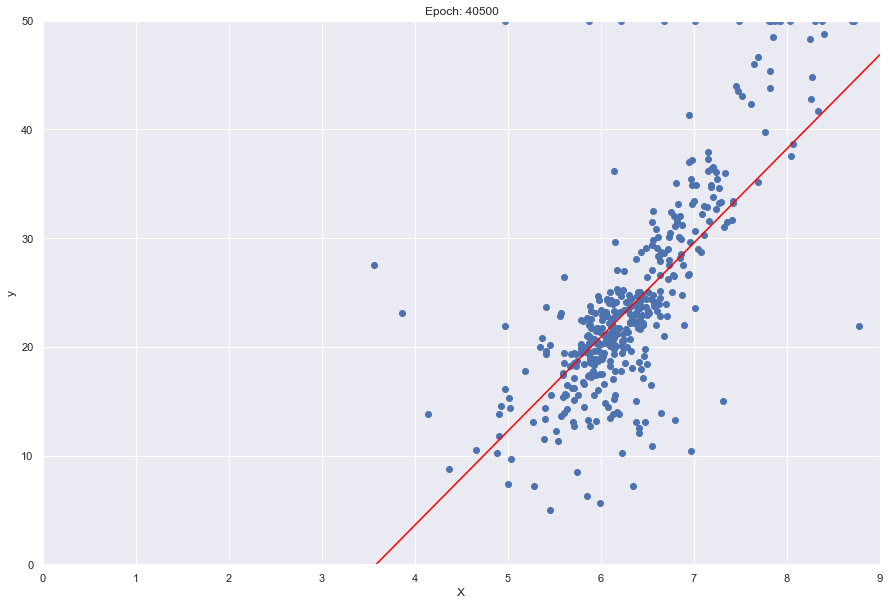

37.75744806496706 9.42568995469275 -35.50178753320467
38.227651836999534 8.65455688457441 -31.007318450367272
epoch:  41000 average loss:  38.0312992369392
Momentum leader: gradient_w2 = 16.19615191775402, gradient_b2 = 3.268491550390012, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 3.893773395446982e-08, mb1 = -2.4989094782727804e-07
Momentum leader: guidance_w2 = 0.9999041130690963, guidance_b2 = 0.9998728418178708
Adam follower: mw2 = -8.58695015762471, mb2 = -1.7086763221998202, sw2 = 0.7374211350681994, sb2 = 0.029198284155661502


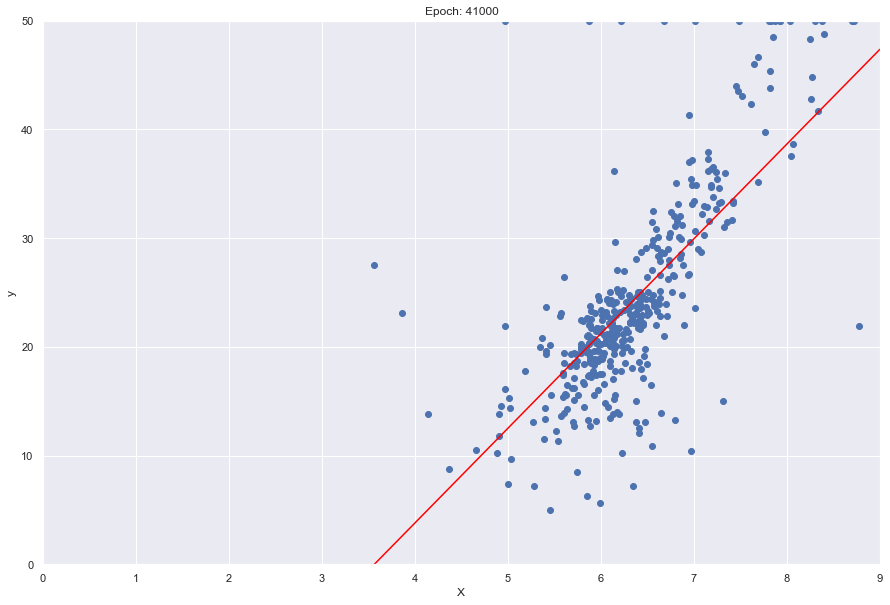

37.75744806133088 9.425710725278355 -35.50192083272785
38.0312992369392 8.713926055398245 -31.051923694082234
epoch:  41500 average loss:  37.99031168816135
Momentum leader: gradient_w2 = 6.064969099958364, gradient_b2 = 2.079635068859204, MAX_w_gradient = 216.62481112358677 and b = 31.73535305443158
Momentum leader: mw1 = 3.42482973457778e-08, mb1 = -2.1979551823846218e-07
Momentum leader: guidance_w2 = 0.9999399314569548, guidance_b2 = 0.9999125719617041
Adam follower: mw2 = -3.5171546697823493, mb2 = -1.1141402379882734, sw2 = 0.12372092155988172, sb2 = 0.012414001266553757


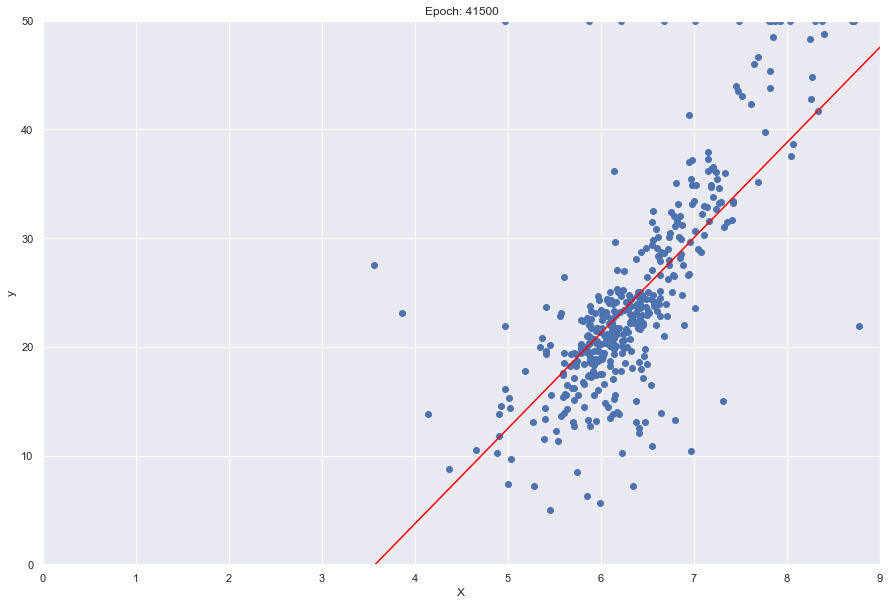

393.23425817489624


In [35]:
start_time = time.time()
w_list, b_list, avg_loss_list, w, b, img_list, pred_val_at_diff_epoch = train(df["RM"][0:403], df["Y"][0:403], 0, 0, 0, 0, 0.001, 1000000, 0.9, 0.99, 0.0000001)
print(f"{time.time() - start_time}")

In [36]:
print(len(w_list))
print(len(b_list))
print(len(avg_loss_list))
print("best value for w: ",w)
print("best value for b: ",b)
print(len(img_list))
print(len(pred_val_at_diff_epoch))

4151
4151
4151
best value for w:  9.42572899437399
best value for b:  -35.50203807842248
84
0


In [37]:
len(avg_loss_list)*10

41510

In [38]:
min(avg_loss_list)

37.757448058517845

In [39]:
n = np.linspace(10, _, 4151, endpoint = True)
len(n)

4151

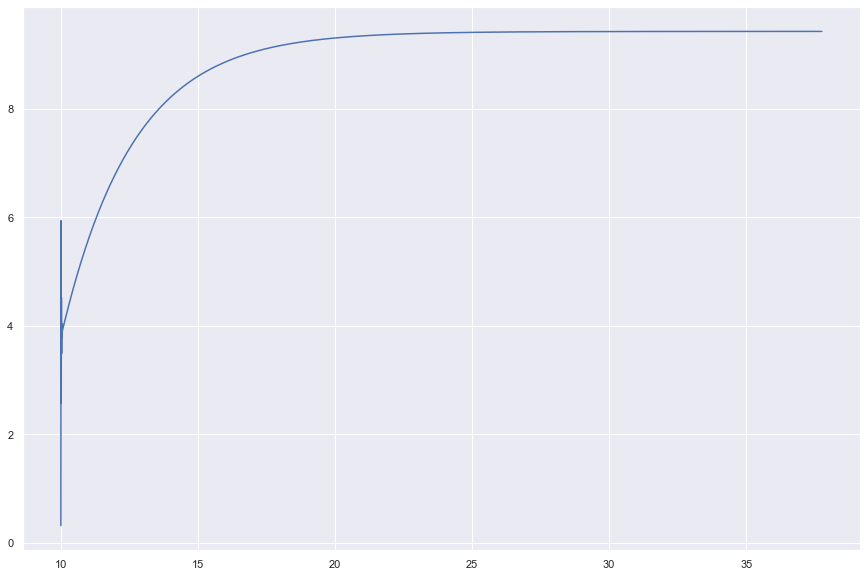

In [40]:
sns.set(rc = {"figure.figsize" : (15, 10)})
plt.plot(n, w_list)
plt.show()

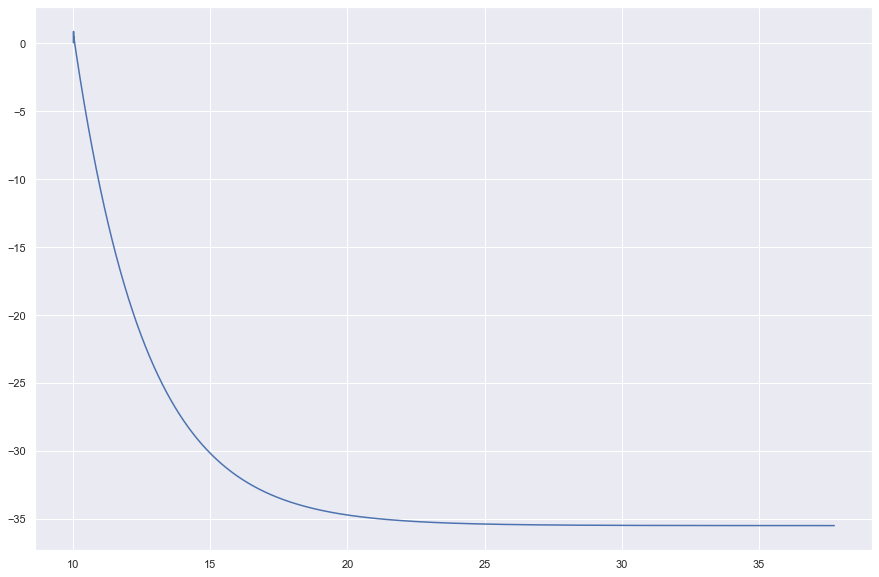

In [41]:
plt.plot(n, b_list)
plt.show()

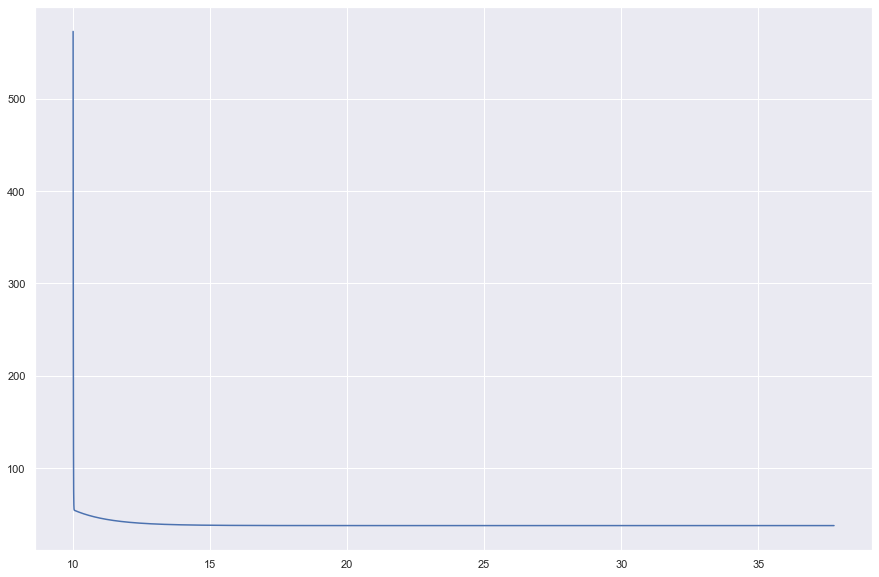

In [42]:
plt.plot(n, avg_loss_list)
plt.show()

In [43]:
import imageio
with imageio.get_writer('gradient_descent_01.gif', mode='I') as writer:
    for filename in img_list:
        image = imageio.imread(filename)
        writer.append_data(image)